# API

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# %load_ext line_profiler

In [2]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [4]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from Chern_insulator import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [3]:
# %%writefile Chern_insulator.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib


class Params:
    def __init__(self,
            Lx=4,
            Ly=16,
            Delta=1,
            t=1,
            m=1,
            bcx=-1,
            bcy=1,
            T=0,
            dxmax=16,
            dymax=16,
            history=False,
            ):
        self.Lx = Lx
        self.Ly = Ly
        self.Delta = Delta
        self.t = t
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        if Lx<np.inf and Ly<np.inf:
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron(np.eye(Ly),hopx)
            hopymat = np.kron(hopy,np.eye(Lx))
            self.hopxmat=hopxmat
            self.hopymat=hopymat
            onsitemat = np.eye(Lx*Ly)
            self.Hamiltonian = ((np.kron(hopxmat-hopxmat.T, self.sigmax)+np.kron(hopymat-hopymat.T, self.sigmay))* 1j*Delta-t*np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T, self.sigmaz))/2+m*np.kron(onsitemat, self.sigmaz)
        elif Lx==np.inf and Ly==np.inf:
            self.dxmax=dxmax
            self.dymax=dymax
            self.dx=lambda kx: Delta*np.sin(kx)
            self.dy=lambda ky: Delta*np.sin(ky)
            self.dz=lambda kx,ky: m-t*np.cos(kx)-t*np.cos(ky)
        else:
            raise ValueError('The size of system {:d,:d} is not supported.'.format(Lx,Ly))
            

    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]

    def fermi_dist_k(self,kx,ky,branch,E_F=0):
        if self.T==0:
            return np.heaviside(E_F-self.E_k(kx,ky,branch),0)
        else:
            return 1/(1+np.exp((self.E_k(kx,ky,branch)-E_F)/self.T))

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix_inf_fft(self,threshold=[1024,512]):
        '''
        self.dxmax/self.dymax: the maximal distance in x/y direction (in terms of unit cell) 
        Directly call fft to evaluate the integral
        '''
        assert self.Lx==np.inf and self.Ly==np.inf, "Wire length should be inf"
        # cov_mat=[]
        Nxmax=max(2*self.dxmax,threshold[0])
        Nymax=max(2*self.dymax,threshold[1])
        if self.T>0:
            pass    #to be filled
        else:
            kxlist=np.arange(0,2*np.pi,2*np.pi/Nxmax)
            kylist=np.arange(0,2*np.pi,2*np.pi/Nymax)
            kxmap,kymap=np.meshgrid(kxlist,kylist)
            dxmap=self.dx(kxmap)
            dymap=self.dy(kymap)
            dzmap=self.dz(kxmap,kymap)
            Ekmap=np.sqrt(dxmap**2+dymap**2+dzmap**2)
            Ekxymap=np.sqrt(dxmap**2+dymap**2)
            costheta=dzmap/Ekmap
            sintheta=Ekxymap/Ekmap
            Ekxymap[0,0]=np.inf #to avoid 0/0 in cos(phi) & sin(phi); the order of this line matters
            cosphi=dxmap/Ekxymap
            sinphi=dymap/Ekxymap
            fftcostheta=np.fft.ifft2(costheta)
            constmap=np.zeros((Nymax,Nxmax))
            constmap[0,0]=0.5
            A_11=constmap-fftcostheta/2
            A_22=constmap+fftcostheta/2
            A_12=np.fft.ifft2(-(cosphi-1j*sinphi)/2*sintheta)
            A_21=np.fft.ifft2(-(cosphi+1j*sinphi)/2*sintheta)
            mat=np.stack([[A_11,A_12],[A_21,A_22]])
            C_f=np.zeros((2*self.dxmax*self.dymax,2*self.dxmax*self.dymax))*1j
            for i in range(self.dxmax*self.dymax):
                for j in range(i):
                    ix,iy=i%self.dxmax,i//self.dxmax
                    jx,jy=j%self.dxmax,j//self.dxmax
                    dx,dy=(ix-jx)%Nxmax,(iy-jy)%Nymax
                    C_f[2*i:2*i+2,2*j:2*j+2]=mat[:,:,dy,dx]
            C_f=C_f+C_f.T.conj()
            for i in range(self.dxmax*self.dymax):
                C_f[2*i:2*i+2,2*i:2*i+2]=mat[:,:,0,0]
            self.C_f=C_f

    def correlation_matrix(self, E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f = ((occupancy_mat*self.vec)@self.vec.T.conj())

    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G = self.C_f
        Gamma_11 = 1j*(G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False, k=2):
        '''
        If proj ==True, then the index used for projection operator will be returned
        k, the size of measurement, is useful only when proj=True
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            assert subregion_x.max()<self.Lx and subregion_y.max()<self.Ly, 'Range exceeds'
            linear_index = ((X+Y*self.Lx).flatten('F'))
        else:
            assert subregion_x.max()<self.dxmax and subregion_y.max()<self.dymax, 'Range exceeds'
            linear_index = ((X+Y*self.dxmax).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, k)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def square_index(self, subregion):
        subregion=np.unique(np.array(subregion)//4)
        if self.Lx<np.inf and self.Ly<np.inf:
            return subregion%self.Lx,subregion//self.Lx
        else:
            return subregion%self.dxmax,subregion//self.dxmax


    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregion_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_f'):
            self.correlation_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 4)

        return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 2)
        subregion_B = self.linearize_index(subregion_B, 2)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 4)
            subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def log_neg(self, subregion_A, subregion_B, Gamma=None,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 4)
            subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)

    def projection(self, s,type='onsite',ignore=False):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        For type:'link'
            (o,+)|(o,-)|(e,+)|(e,-)
        '''
        if type=='onsite':
            assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
            blkmat = np.array([[0, -(-1)**s, 0, 0],
                            [(-1)**s, 0, 0, 0],
                            [0, 0, 0, (-1)**s],
                            [0, 0, -(-1)**s, 0]])
            return blkmat
        if type=='link':
            assert (s in ['o+','o-','e+','e-']), "s={} for {} is not defined".format(s,type)
            if s=='o+':
                antidiag=[1,-1,1,-1]
                blkmat=np.diag(antidiag)
                blkmat=np.fliplr(blkmat)
            if s=='o-':
                antidiag=[-1,1,-1,1]
                blkmat=np.diag(antidiag)
                blkmat=np.fliplr(blkmat)
            if not ignore:
                if s=='e+':
                    blkmat=np.array([[0,-1,0,0],
                                    [1,0,0,0],
                                    [0,0,0,-1],
                                    [0,0,1,0]])
                if s=='e-':
                    blkmat=-np.array([[0,-1,0,0],
                                    [1,0,0,0],
                                    [0,0,0,-1],
                                    [0,0,1,0]])
            else:
                if s=='e+':
                    antidiag=[-1,-1,1,1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)
                if s=='e-':
                    antidiag=[1,1,-1,-1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)
            proj=np.zeros((8,8))
            proj[:4,:4]=blkmat
            proj[4:,4:]=blkmat.T
            return proj   
        if type=='correlated':
            assert (s in ['10','01']), "s={} for {} is not defined".format(s,type)
            if s=='10':
                blkmat=np.array([[0,-1,0,0],
                                 [1,0,0,0],
                                 [0,0,0,1],
                                 [0,0,-1,0]])
            if s=='01':
                blkmat=np.array([[0,1,0,0],
                                 [-1,0,0,0],
                                 [0,0,0,-1],
                                 [0,0,1,0]])
            proj=np.zeros((8,8))
            proj[:4,:4]=blkmat
            proj[4:,4:]=blkmat.T
            return proj


        raise ValueError("type '{}' is not defined".format(type))

    def measure(self, s, ix,type='onsite',ignore=False):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s,type=type,ignore=ignore)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(ix[0])
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [ix[0]]

    def measure_all_Born(self, proj_range,prob=None,linear=False,type='onsite',pool=4,ignore=False):
        if not linear:
            if type=='onsite':
                proj_range = self.linearize_index(proj_range, 4, proj=True)
            if type=='link' or type=='correlated':
                proj_range = self.linearize_index(proj_range, 4, proj=True,k=4)
        # self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.f_parity= []
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if type=='onsite':
            for index,i in enumerate(proj_range):
                if prob is None:
                    P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
                else:
                    if isinstance(prob,list):
                        assert len(prob)==len(proj_range), "len of prob {:d} not equal to len of proj_range {:d}".format(len(prob),len(proj_range))
                        P_0=prob[index]
                    else:    
                        P_0=prob
                self.P_0_list.append(P_0)
                if np.random.rand() < P_0:
                    self.measure(0, [i, i+1])
                    self.f_parity.append(0)
                else:
                    self.measure(1, [i, i+1])
                    self.f_parity.append(1)
            return self

        if type=='link':
            for i in proj_range:
                Gamma=self.C_m_history[-1][i:i+4,i:i+4]
                P={}
                if prob is None:
                    gamma1234=-Gamma[0,1]*Gamma[2,3]+Gamma[0,2]*Gamma[1,3]-Gamma[0,3]*Gamma[1,2]
                    P['o+']=(1+Gamma[1,2]-Gamma[0,3]+gamma1234)/4
                    P['o-']=(1-Gamma[1,2]+Gamma[0,3]+gamma1234)/4
                    if not ignore:
                        P['e+']=(1+Gamma[0,1]+Gamma[2,3]-gamma1234)/4
                        P['e-']=(1-Gamma[0,1]-Gamma[2,3]-gamma1234)/4
                    else:
                        #ignore symmetry
                        P['e+']=(1+Gamma[1,2]+Gamma[0,3]-gamma1234)/4
                        P['e-']=(1-Gamma[1,2]-Gamma[0,3]-gamma1234)/4
                else:
                    P['o+'],P['o-'],P['e+'],P['e-']=tuple(prob)

                # print((P.values()))
                if pool==4:
                    s=np.random.choice(['o+','o-','e+','e-'],p=[P['o+'],P['o-'],P['e+'],P['e-']])
                elif pool==2:
                    s=np.random.choice(['o+','o-'],p=[P['o+']/(P['o+']+P['o-']),P['o-']/(P['o+']+P['o-'])])
                elif pool==-2:
                    s=np.random.choice(['e+','e-'],p=[P['e+']/(P['e+']+P['e-']),P['e-']/(P['e+']+P['e-'])])
                self.measure(s,[i,i+1,i+2,i+3],type='link',ignore=ignore)
            return self
        if type=='correlated':
            for i in proj_range:
                Gamma=self.C_m_history[-1][i:i+4,i:i+4]
                P={}
                if prob is None:
                    gamma1234=-Gamma[0,1]*Gamma[2,3]+Gamma[0,2]*Gamma[1,3]-Gamma[0,3]*Gamma[1,2]
                    P['10']=(1+Gamma[0,1]-Gamma[2,3]+gamma1234)/4
                    P['01']=(1-Gamma[0,1]+Gamma[2,3]+gamma1234)/4
                else:
                    P['10'],P['01']=tuple(prob)
                s=np.random.choice(['10','01'],p=[P['10']/(P['10']+P['01']),P['01']/(P['10']+P['01'])])
                self.measure(s,[i,i+1,i+2,i+3],type=type)
            return self



    def fermion_number(self,proj_range,linear=False,type='C_m'):
        if type=='C_m':
            if not linear:
                proj_range = self.linearize_index(proj_range, 4, proj=True,k=2)
            return 1/2*(1-np.diagonal(self.C_m_history[-1],1)[proj_range]).sum()
        # if type=='C_f':
        #     if not linear:
        #         proj_range = self.linearize_index(proj_range, 2, proj=True,k=1)
        #     return np.trace(self.C_f[proj_range])

    def snap_prob(self,proj_range,occ,linear=False):

        if not linear:
            proj_range= self.linearize_index(proj_range,4,proj=True,k=2)
        return (1-(-1)**occ*np.diagonal(self.C_m,1)[proj_range])/2


def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

# Test

In [233]:
params=Params(m=0,Lx=24,Ly=24,bcx=0,bcy=0)
params.covariance_matrix()

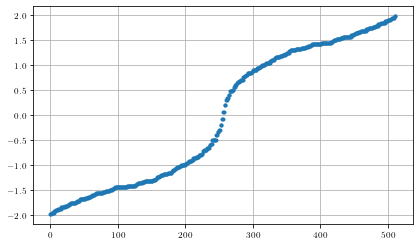

In [229]:
fig,ax=plt.subplots()
ax.plot(params.val,'.')
# ax.set_ylim([-1,1])
# ax.set_xlim([params.val.shape[0]//2-30,params.val.shape[0]//2+30])
ax.grid('on')

In [224]:
params.val[params.vec.shape[0]//2-4:params.vec.shape[0]//2+4]

array([-1.22407006, -1.14428229, -1.14284125, -1.05954057,  1.05954057,
        1.14284125,  1.14428229,  1.22407006])

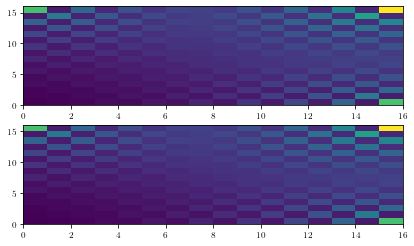

In [230]:
fig,ax=plt.subplots(2,1)
level=params.vec.shape[0]//2
ax[0].pcolormesh(params.vec[:,level][::2].reshape((params.Lx,params.Ly)).__abs__())
ax[1].pcolormesh(params.vec[:,level][1::2].reshape((params.Lx,params.Ly)).__abs__())

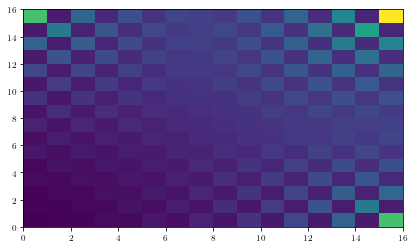

In [231]:
fig,ax=plt.subplots()
level=params.vec.shape[0]//2+0
ax.pcolormesh(params.vec[:,level][::2].reshape((params.Lx,params.Ly)).__abs__()+params.vec[:,level][1::2].reshape((params.Lx,params.Ly)).__abs__())

In [134]:
z1=params.c_subregion_f([np.arange(12,20),np.arange(12,20)])

In [135]:
z2=params.c_subregion_f([np.arange(6),np.arange(6)])

In [136]:
val,vec=nla.eigh(z1)

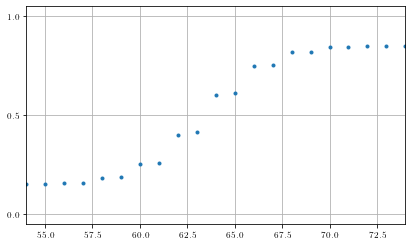

In [232]:
fig,ax=plt.subplots()
ax.plot(val,'.')
ax.set_xlim([val.shape[0]//2-10,val.shape[0]//2+10])
ax.set_yticks([0,.5,1])
ax.grid('on')

In [138]:
val,vec=nla.eigh(z2)

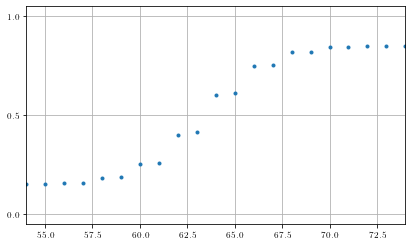

In [139]:
fig,ax=plt.subplots()
ax.plot(val,'.')
ax.set_xlim([val.shape[0]//2-10,val.shape[0]//2+10])
ax.set_yticks([0,.5,1])
ax.grid('on')

In [ ]:

params.fermion_number([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])

In [ ]:
16*16/4

In [ ]:
np.round(params.C_m[:4,:4],5)

In [ ]:
params.measure_all_Born([params.])

In [ ]:
params_inf=Params(m=1,dxmax=32,dymax=8,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1)
params_inf.covariance_matrix()

In [ ]:
print(np.round(params.C_m[0,:],10))

In [ ]:
print(np.round(params_inf.C_m[0,:],10))

In [ ]:
zz=params_inf.C_f[0,params_inf.linearize_index([np.arange(params_inf.dxmax),[0]],2)[::2]]

In [ ]:
fig,ax=plt.subplots()
ax.plot((np.real(zz)),'.')
# ax.set_yscale('log')


In [ ]:
zz[0]*np.exp(-1)

In [ ]:
(np.real(zz))

In [ ]:
isinstance([1,2,3],list)

In [ ]:
Gmat_real_jl=np.loadtxt('Gmat_real.txt')

In [ ]:
Gmat_imag_jl=np.loadtxt('Gmat_imag.txt')

In [ ]:
np.abs(Gmat_imag_jl*1j+Gmat_real_jl-params.C_m).max()

In [ ]:
np.round(np.real(params.C_f[:8,:8]),3)

In [ ]:
params.C_m

In [ ]:
print(np.round(params.hopxmat,0))

In [ ]:
print(np.round(params.hopymat,0))

In [ ]:
np.round(np.real(params.C_f[:8,:8]),3)

In [ ]:
np.round(np.real(params.C_f[0,:]),3)

In [ ]:
np.round(np.real(params.C_m[:8,:8]),3)

In [ ]:
params.Hamiltonian

In [ ]:
np.imag(params.Hamiltonian[:8,:8])

In [ ]:
np.trace(params_L.C_f)

In [ ]:
np.fft.fftshift(np.arange(8))

In [ ]:
(-1)%8

In [ ]:
[np.arange(params_L.Lx//4),np.arange(params_L.Ly)]

In [ ]:
[np.arange(params_L.Lx//4)+params_L.Lx//2,np.arange(params_L.Ly)]

In [ ]:
params_L.log_neg([np.arange(params_L.Lx//4),np.arange(params_L.Ly)],[np.arange(params_L.Lx//4)+params_L.Lx//2,np.arange(params_L.Ly)])

In [ ]:
params_L.eA,params_L.sA

In [ ]:
np.round(params_L.C_m[4:8,0:4],10)

In [ ]:
params=Params(Lx=np.inf,Ly=np.inf,m=1,dxmax=32,dymax=8)

In [ ]:
params.covariance_matrix()

In [ ]:
np.trace(params.C_f)

In [ ]:
[np.arange(params.dxmax//4),np.arange(params.dymax)]

In [ ]:
[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]

In [ ]:
params.log_neg([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)])

In [ ]:
params.log_neg([np.arange(8),np.arange(params.dymax)],[np.arange(8)+16,np.arange(params.dymax)])

In [ ]:
list(np.diag(np.round(params.C_m@params.C_m,10)))

In [ ]:
np.round(params_L.C_m@params_L.C_m,10)[:4,:4]

In [ ]:
np.round(params.C_m[4:8,0:4],10)

In [ ]:
params.eA,params.A

In [ ]:
np.imag(params_L.C_f).max()

In [ ]:
np.round((params_L.C_f[156:158,76:78]),10)

In [ ]:
np.round((params_L.C_f[80:82,0:2]),10)

In [ ]:
np.round((params_L.C_f[64:66,0:2]),10)

In [ ]:
params.correlation_matrix_inf_fft()

In [ ]:
np.round(params.C_f[64:66,0:2],10)

In [ ]:
(np.imag(params.C_f)).max()

In [ ]:
(np.imag(params_L.C_f)).max()

In [ ]:
params.covariance_matrix()

In [ ]:
np.round((params.C_f[80:82,:2]),10)

In [ ]:
np.round((params.C_f[156:158,76:78]),10)

In [ ]:
np.where(np.imag(params_L.C_f)==np.imag(params_L.C_f).max())

In [ ]:
params_L.C_f[0:2,32:34]

In [ ]:
params_L.C_f[28:30,60:62]

In [ ]:
print(params_L.C_f[6:8,0:2])

In [ ]:
print(params_L.C_f[32:34,0:2])

In [ ]:
17//8

In [ ]:
print(params_L.C_f[34:36,0:2])

In [ ]:
np.array([[A11[1,2],A12[1,2]],[A21[1,2],A22[1,2]]])

In [ ]:
print(params_L.C_f[2:4,0:2])

In [ ]:
np.array([[A11[1,0],A12[1,0]],[A21[1,0],A22[1,0]]])

In [ ]:
zz[:,:,1,0]

In [ ]:
zz=np.stack([[A11,A12],[A21,A22]])

In [ ]:
A11[0,1],A12[0,1],A21[0,1],A22[0,1]

In [ ]:
A12[1,0]

In [ ]:
np.imag(params.C_f)

In [ ]:
print(np.round(np.real(params.C_m@params.C_m),9))

In [ ]:
params=Params(Lx=64,Ly=4,m=1.,history=True)
proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
params.measure_all_Born(proj_range_0,type='link',prob=[1,0,0,0],linear=True)
params.measure_all_Born(proj_range_1,type='link',pool=-2,linear=True)
params.measure_all_Born(proj_range_2,type='link',prob=[1,0,0,0],linear=True)
# params.measure_all_Born(proj_range_0[len(proj_range_0)//2:len(proj_range_0)//2+1],type='link',prob=[0,0,1,0],linear=True)
# params.measure_all_Born(proj_range_1,type='link',linear=True)
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))

In [ ]:
params.fermion_number()

In [ ]:
params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])

In [ ]:
params=Params(Lx=64,Ly=4,m=1,history=True)
proj_range_0=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
proj_range_1=params.linearize_index([np.arange(params.Lx//4)+3*params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
params.measure_all_Born(proj_range_0,type='link',linear=True,ignore=False)
params.measure_all_Born(proj_range_1,type='link',linear=True,ignore=False)
# params.measure_all_Born(proj_range_1,type='link',prob=[1,0,0,0],linear=True)
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))

In [ ]:
params.fermion_number([np.arange(params.Lx),np.arange(params.Ly)])

In [ ]:
params=Params(Lx=64,Ly=4,m=-1.2,history=True)
proj_range=params.linearize_index([np.arange(params.Lx//4,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=2)
prob_list=[(1-(-1)**i)/2 for i,x in enumerate(proj_range)]
params.measure_all_Born(proj_range_0,type='onsite',prob=prob_list,linear=True)
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))

In [ ]:
params.C_m_history[-1][proj_range[0]:proj_range[0]+4,proj_range[0]:proj_range[0]+4]

In [ ]:
params.measure_all_Born(proj_range[-1:],type='link',prob=[0,1,0,0],linear=True)

In [ ]:
np.round(params.C_m_history[-1][proj_range[-2]:proj_range[-2]+8,proj_range[-2]:proj_range[-2]+8],3)

In [ ]:
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))

In [ ]:
(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


In [ ]:
params.s_history

In [ ]:
print(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
# print(params.mutual_information_f([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))



In [ ]:
sum(params.f_parity)

In [ ]:
np.round((params.C_m_history)[0][16:24,16:24],2)

In [ ]:
np.round((params.C_m_history)[1][16:24,16:24],2)

In [ ]:
np.round((params.C_m_history)[2][16:24,16:24],2)

In [ ]:
params.i_history

In [ ]:
params.s_history

In [ ]:
params.P_0_list

In [ ]:
params.von_Neumann_entropy_f([np.arange(params.Lx//4),np.arange(params.Ly)])

In [ ]:
params.von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

In [ ]:
(params.mutual_information_f([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


In [ ]:
(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


In [ ]:
params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],1)

In [ ]:
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


In [ ]:
params.von_Neumann_entropy_f([[0,1],np.arange(params.Ly)])

In [ ]:
params.von_Neumann_entropy_m([[0,1],np.arange(params.Ly)])

In [ ]:
params.mutual_information_f([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

In [ ]:
params.mutual_information_m([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

In [ ]:
params.log_neg([[0,1],np.arange(params.Ly)],[[16,17],np.arange(params.Ly)])

# Bandstructrue

In [ ]:
m_list=np.linspace(0,3)
eigval_pbc_list=[]
for m in m_list:
    params=Params(m=m,bcx=1,bcy=1,Lx=16,Ly=16,Delta=1)
    params.bandstructure()
    eigval_pbc_list.append(params.val)


In [ ]:
m_list=np.linspace(0,3)
eigval_apbc_list=[]
for m in m_list:
    params=Params(m=m,bcx=-1,bcy=1,Lx=16,Ly=16,Delta=1)
    params.bandstructure()
    eigval_apbc_list.append(params.val)


In [ ]:
func=lambda kx,ky,m,t,Delta:np.sqrt((t*np.sin(kx))**2+(t*np.sin(ky))**2+(m-Delta*np.cos(kx)-Delta*np.cos(ky))**2)

In [ ]:
KX,KY=np.meshgrid(np.linspace(-np.pi,np.pi),np.linspace(-np.pi,np.pi))

In [ ]:
en_max=[]
en_min=[]
for m in m_list:
    en=func(KX,KY,m,1,1)
    en_max.append(en.max())
    en_min.append(en.min())

In [ ]:
fig,ax=plt.subplots(1,2,sharey=True,sharex=True,tight_layout=True)
ax[0].plot(m_list,eigval_apbc_list,'c',lw=0.5)
ax[1].plot(m_list,eigval_pbc_list,'c',lw=0.5)
ax[0].set_xlabel(r'm')
ax[0].set_ylabel(r'Energy')
ax[1].plot(m_list,en_min,'r',lw=3)
ax[1].plot(m_list,en_max,'r',lw=3)
ax[0].margins(x=0)
ax[0].set_title('x: APBC, y: PBC')
ax[1].set_title('x,y: PBC')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/bs.pdf',bbox_inches='tight')

# No measurement

## finite

In [4]:
# m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,40))
m_list=np.linspace(-4,4,20)
LN_no_list=[]
MI_no_list=[]
Lx,Ly=64,4
for m in m_list:
    params=Params(m=m,Lx=Lx,Ly=Ly)
    MI_no_list.append(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    LN_no_list.append(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


Text(0.5, 1.0, 'Finite system')

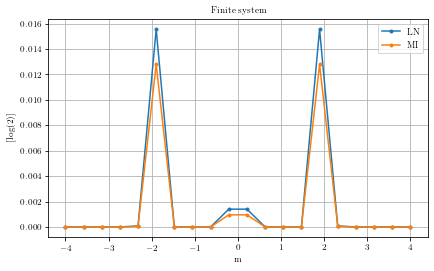

In [5]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list/np.log(2),'.-',label='LN')
ax.plot(m_list,MI_no_list/np.log(2),'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.grid('on')
ax.set_ylabel('[log(2)]')
ax.set_title('Finite system')
# fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_CI_no_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Inf

In [ ]:
# m_list=np.linspace(1,3,20)
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,20))
LN_no_inf_list=[]
MI_no_inf_list=[]
for m in m_list:
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=32,dymax=8)
    MI_no_inf_list.append(params.mutual_information_m([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))
    LN_no_inf_list.append(params.log_neg([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))

In [ ]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_inf_list,'.-',label='LN')
ax.plot(m_list,MI_no_inf_list,'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.set_title('Infinite system')
# fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_CI_no_inf_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')


# Measure to 0

In [6]:
m_list=np.linspace(1,3,20)
es=1
LN_empty_list=np.zeros((len(m_list),es))
MI_empty_list=np.zeros((len(m_list),es))
Lx,Ly=16,4
for m_i,m in enumerate(m_list):
    # st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0)
        MI_empty_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_empty_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_empty_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


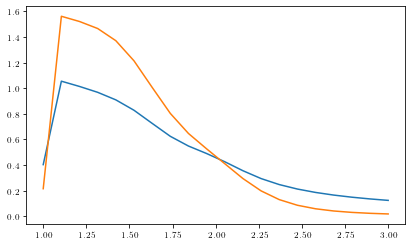

In [7]:
plt.plot(m_list,LN_empty_list)
plt.plot(m_list,MI_empty_list)

# Measure to 0.5

In [ ]:
m_list=np.linspace(1,3,20)
es=50
LN_half_list=np.zeros((len(m_list),es))
MI_half_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=16,Ly=8)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0.5)
        # MI_half_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_half_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    #  # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])],0.5).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_half_list[m_i,:]=async_result 

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
plt.plot(m_list,LN_half_list.mean(axis=1))
# plt.plot(m_list,LN_empty_list)

# Measure to 1

In [23]:
m_list=np.linspace(1,3,20)
es=1
LN_occ_list=np.zeros((len(m_list),es))
MI_occ_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],1)
        MI_occ_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_occ_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_occ_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


<ipython-input-21-450f7102a9e6>:401: LinAlgWarning: Ill-conditioned matrix (rcond=8.32667e-17): result may not be accurate.
  Psi = mat1+mat2@(la.solve(mat3, mat2.T))


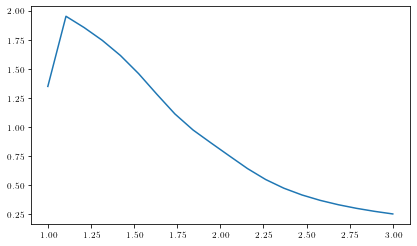

In [24]:
plt.plot(m_list,LN_occ_list)
# plt.plot(m_list,LN_empty_list)

In [170]:
# prob=list(np.random.permutation([1,0]*(Lx//4*Ly)))
prob=([1,0]*(Lx//4*Ly))
# prob=([0,1]*(Lx//4*Ly))

In [185]:
prob_list=[prob]
prob1=copy(prob)
for i in range(Lx//4*Ly):
    prob1[2*i],prob1[2*i+1]=prob1[2*i+1],prob1[2*i]
    prob2=copy(prob1)
    prob_list.append(prob2)

In [462]:
prob=[1,0]*(Lx//4*1)+[0,1]*(Lx//4*(Ly-1))


In [318]:
params.square_index([1,2,3,4,5,6,7,8,9])

(array([0, 1, 2]), array([0, 0, 0]))

In [450]:
Lx*Ly*2//4

64

In [357]:
params.fermion_number([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='C_m')

32.0

In [197]:
def run(p):
    Lx,Ly,m,prob=p
    params=Params(m=m,Lx=Lx,Ly=Ly)
    # prob=list(np.random.permutation([1,0]*(Lx//4*Ly)))
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],prob=prob)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    fn=params.fermion_number([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    total_prob=params.snap_prob([np.arange(Lx//4,Lx//2),np.arange(Ly)],occ=np.array(prob)).prod()
    return LN,fn,total_prob

In [198]:
run((Lx,Ly,1,prob_list[0]))

(0.6941249447928497, 32.0, 7.25798592078013e-09)

In [196]:
run((Lx,Ly,1,prob_list[0]))

(0.6941249238817029, 32.0, 7.257985923839278e-09)

In [156]:
run((Lx,Ly,1,prob))

(0.6957639042394876, 32.0, 9.723760770203726e-11)

In [87]:
inputs[1][3]

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [7]:
import itertools

In [34]:
nchoosek=list(itertools.combinations(np.arange(Lx*Ly//4),1))

In [49]:
nchoosek

[()]

In [94]:
Lx=32
Ly=4

In [96]:
prob=([1,0]*(Lx//4*Ly))
prob1_list=[prob]
for k in range(1,2):
    nchoosek=list(itertools.combinations(np.arange(Lx*Ly//4),k))
    for i1 in (nchoosek):
        for i2 in (nchoosek):
            prob1=copy(prob)
            prob1=np.array(prob1)
            prob1[2*np.array(list(i1))]=0
            prob1[2*np.array(list(i2))+1]=1
            prob1_list.append(list(prob1))



In [116]:
np.array(prob1_list[4])

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [117]:
LN_list[4]

0.06532565187147998

In [ ]:
prob_list=[prob]
prob1=copy(prob)
for i in range(Lx//4*Ly):
    prob1[2*i],prob1[2*i+1]=prob1[2*i+1],prob1[2*i]
    prob2=copy(prob1)
    prob_list.append(prob2)

In [741]:
# es=100
Lx=32
Ly=4
inputs=[(Lx,Ly,1,prob) for prob in prob_list]
LN_samesite_list=np.zeros(len(prob_list))
fn_samesite_list=np.zeros(len(prob_list))
total_prob_samesite_list=np.zeros(len(prob_list))

sync=rc[:].map_sync(run,inputs)
for es_i,result in enumerate(sync):
    LN,fn,total_prob=result
    LN_samesite_list[es_i]=(LN)
    fn_samesite_list[es_i]=(fn)
    total_prob_samesite_list[es_i]=(total_prob)
    

In [743]:
total_prob_samesite_list

array([7.25798592e-09, 8.40088797e-10, 9.72376077e-11, 1.12549440e-11,
       1.30272399e-12, 1.50786160e-13, 1.74530187e-14, 2.02013143e-15,
       2.33823791e-16, 2.70643605e-17, 3.13261369e-18, 3.62590077e-19,
       4.19686487e-20, 4.85773767e-21, 5.62267693e-22, 6.50806980e-23,
       7.53288391e-24, 8.71907366e-25, 1.00920506e-25, 1.16812277e-26,
       1.35206497e-27, 1.56497223e-28, 1.81140560e-29, 2.09664440e-30,
       2.42679924e-31, 2.80894298e-32, 3.25126220e-33, 3.76323264e-34,
       4.35582215e-35, 5.04172567e-36, 5.83563719e-37, 6.75456453e-38,
       7.81819372e-39])

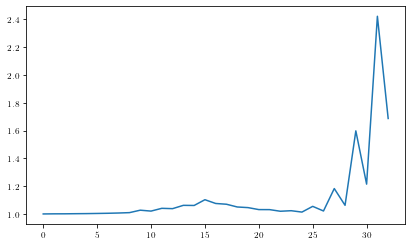

In [745]:
plt.plot(LN_samesite_list/np.log(2))

In [99]:
# es=100
Lx=32
Ly=4
inputs=[(Lx,Ly,1,prob) for prob in prob1_list]
LN_list=np.zeros(len(prob1_list))
fn_list=np.zeros(len(prob1_list))
total_prob_list=np.zeros(len(prob1_list))

sync=rc[:].map_sync(run,inputs)
for es_i,result in enumerate(sync):
    LN,fn,total_prob=result
    LN_list[es_i]=(LN)
    fn_list[es_i]=(fn)
    total_prob_list[es_i]=(total_prob)
    

In [89]:
LN_list[4]

0.20317456384611177

In [123]:
kmax=2
Lx=32
Ly=4
m=1
with open('CI_kmax{:d}_Lx{:d}_Ly{:d}_m{:.1f}.pickle'.format(kmax,Lx,Ly,m),'rb') as f:
    [LN_map,fn_map,total_prob_map]=pickle.load(f)

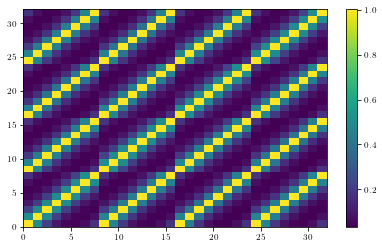

In [131]:
plt.pcolormesh((LN_map[1]/np.log(2)).reshape((32,32)))
plt.colorbar()

In [41]:
fn_list

array([32., 32., 32., ..., 32., 32., 32.])

(array([376.,  72., 112., 112.,   0.,   0.,   0.,  40.,  96.,  88.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 129.]),
 array([0.03291518, 0.08138407, 0.12985296, 0.17832185, 0.22679075,
        0.27525964, 0.32372853, 0.37219742, 0.42066631, 0.46913521,
        0.5176041 , 0.56607299, 0.61454188, 0.66301077, 0.71147966,
        0.75994856, 0.80841745, 0.85688634, 0.90535523, 0.95382412,
        1.00229302]),
 <BarContainer object of 20 artists>)

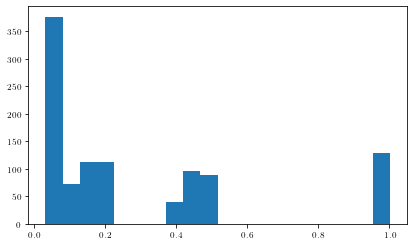

In [106]:
plt.hist(LN_list/np.log(2),bins=20)

In [100]:
np.sum(total_prob_list*LN_list)/np.sum(total_prob_list)/np.log(2)

0.29595625387742514

In [93]:
np.sum(total_prob_list*LN_list)/np.sum(total_prob_list)/np.log(2)

0.588092687258667

In [412]:
np.sum(total_prob)

6.508069802127115e-23

In [429]:
params=Params(m=.1,Lx=Lx,Ly=Ly)
params.covariance_matrix()

In [430]:
params.snap_prob([np.arange(Lx//4,Lx//2),np.arange(Ly)],occ=np.array(prob))

array([0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798, 0.5398798,
       0.5398798, 0.5398798, 0.5398798, 0.5398798])

In [379]:
params.snap_prob([np.arange(Lx//4,Lx//2),np.arange(Ly)],occ=np.array([0]*(Lx//4*Ly*2)))

array([0.25385153, 0.74614847, 0.25385153, 0.74614847, 0.25385153,
       0.74614847, 0.25385153, 0.74614847, 0.25385153, 0.74614847,
       0.25385153, 0.74614847, 0.25385153, 0.74614847, 0.25385153,
       0.74614847, 0.25385153, 0.74614847, 0.25385153, 0.74614847,
       0.25385153, 0.74614847, 0.25385153, 0.74614847, 0.25385153,
       0.74614847, 0.25385153, 0.74614847, 0.25385153, 0.74614847,
       0.25385153, 0.74614847, 0.25385153, 0.74614847, 0.25385153,
       0.74614847, 0.25385153, 0.74614847, 0.25385153, 0.74614847,
       0.25385153, 0.74614847, 0.25385153, 0.74614847, 0.25385153,
       0.74614847, 0.25385153, 0.74614847, 0.25385153, 0.74614847,
       0.25385153, 0.74614847, 0.25385153, 0.74614847, 0.25385153,
       0.74614847, 0.25385153, 0.74614847, 0.25385153, 0.74614847,
       0.25385153, 0.74614847, 0.25385153, 0.74614847])

In [463]:
m_list=np.linspace(0,3,20)
# m_list=-np.linspace(1,3,20)
es=1
LN_pn_list=np.zeros((len(m_list),es))
MI_pn_list=np.zeros((len(m_list),es))
Lx,Ly=32,4
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],prob=prob)
        MI_pn_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_pn_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_pn_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [288]:
LN_pn_list_L32=LN_pn_list

In [283]:
LN_pn_list_L64=LN_pn_list

Text(0, 0.5, 'LN [log2]')

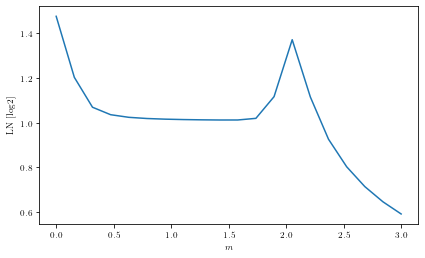

In [464]:
# plt.plot(m_list,LN_pn_list_L32/np.log(2),'k')
# plt.plot(m_list,LN_pn_list_L64/np.log(2),'b')
plt.plot(m_list,LN_pn_list/np.log(2))
plt.xlabel('$m$')
plt.ylabel('LN [log2]')

In [ ]:
# Satisfies Born rule with post selection of half-filling?

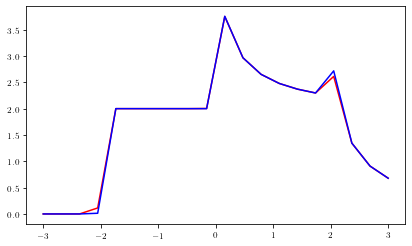

In [90]:
# plt.plot(m_list,LN_pn_list_L64/np.log(2),'r')
plt.plot(m_list,MI_pn_list_L64/np.log(2),'r')
# plt.plot(m_list,LN_pn_list_L128/np.log(2))
plt.plot(m_list,MI_pn_list_L128/np.log(2),'b')

In [86]:
m_list=np.linspace(-3,3,20)
# m_list=-np.linspace(1,3,20)
es=1
LN_pn_list_L128=np.zeros((len(m_list),es))
MI_pn_list_L128=np.zeros((len(m_list),es))
Lx,Ly=128,4
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],prob=([0,1]*(params.Lx//4*params.Ly)))
        MI_pn_list_L128[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_pn_list_L128[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])


In [88]:
m_list=np.linspace(-3,3,20)
# m_list=-np.linspace(1,3,20)
es=1
LN_pn_list_L64=np.zeros((len(m_list),es))
MI_pn_list_L64=np.zeros((len(m_list),es))
Lx,Ly=64,4
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],prob=([0,1]*(params.Lx//4*params.Ly)))
        MI_pn_list_L64[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_pn_list_L64[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])


In [43]:
params.fermion_number([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])

64.0

# Born measurement

## Correlated link

In [40]:
m=1
Lx=32
Ly=4
params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=-1)
params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='correlated')
# ,prob=([1,0]*(Lx//4*Ly))
params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])

0.007711877141066914

In [26]:
np.log(2)

0.6931471805599453

In [803]:
nocc=1/2*(1-(np.diag(params.C_m_history[-1],1)[::2])).reshape((params.Ly,params.Lx,2))

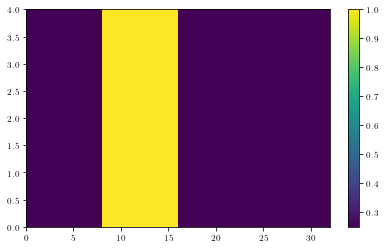

In [804]:
plt.pcolormesh(nocc[:,:,0])
plt.colorbar()

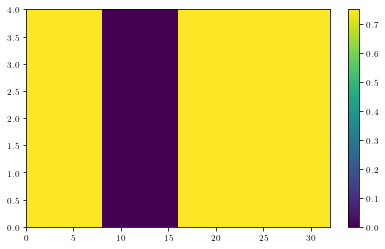

In [805]:
plt.pcolormesh(nocc[:,:,1])
plt.colorbar()

In [160]:
def run(p):
    Lx,Ly,m=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=0)
    # prob=list(np.random.permutation([1,0]*(Lx//4*Ly)))
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='correlated',prob=[1,0])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    fn=params.fermion_number([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    # total_prob=params.snap_prob([np.arange(Lx//4,Lx//2),np.arange(Ly)],occ=np.array(prob)).prod()
    return LN,fn

In [161]:
run((64,4,1))

(0.5286744127255583, 64.0)

In [848]:
l_list=np.arange(4,Lx)
LN_Ly_list=[]
fn_Ly_list=[]
for l in l_list:
    LN,fn=run((32,l,1))
    fn_Ly_list.append(fn)
    LN_Ly_list.append(LN)

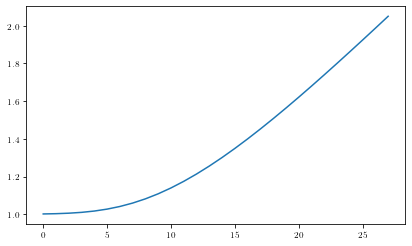

In [850]:
plt.plot(LN_Ly_list/np.log(2))

In [ ]:
es=10
Lx=32
Ly=4
m_list=np.linspace(1,3,11)
LN_Born_list=np.zeros((m_list.shape[0],es))
fn_Born_list=np.zeros((m_list.shape[0],es))
# total_prob_Born_list=np.zeros((m_list.shape[0],es))
for m_i,m in enumerate(m_list):
    inputs=[(Lx,Ly,m) for _ in range(es)]
    sync=rc[:].map_sync(run,inputs)

    for es_i,result in enumerate(sync):
        LN,fn=result
        LN_Born_list[m_i,es_i]=(LN)
        fn_Born_list[m_i,es_i]=(fn)
        # total_prob_Born_list[m_i,es_i]=(total_prob)
    
    

In [44]:
es=100
Lx=32
Ly=8
with open('/mnt/d/KITP/Rp_SPT/8/CI_Born_En{:d}_Lx{:d}_Ly{:d}_{:s}.pickle'.format(es,Lx,Ly,'correlated'),'rb') as f:
    [m_list,MI_Born_list,LN_Born_list,fn_Born_list]=pickle.load(f)

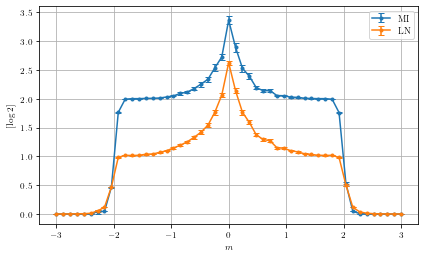

In [45]:
fig,ax=plt.subplots()

ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2)/np.sqrt(es),capsize=3,fmt='.-',label='MI')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2)/np.sqrt(es),capsize=3,fmt='.-',label='LN')
ax.set_xlabel(r'$m$')
ax.set_ylabel('[log 2]')
ax.legend()
ax.grid('on')

fig.savefig('/mnt/d/KITP/Rp_SPT/8/CI_correlated_link_es{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly))

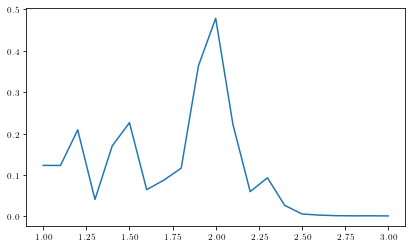

In [867]:
plt.plot(m_list,[LN[fn==32].mean() for fn,LN in zip(fn_Born_list,LN_Born_list)])

## onsite

In [14]:
m_list=np.linspace(1,3,10)
es=20
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_list[m_i,index],LN_Born_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:33.7
1:35.7
2:28.2
3:28.0
4:28.4
5:28.1
6:31.5
7:33.2
8:33.0
9:33.4


In [ ]:
es,Lx,Ly=500,16,32
with open('/mnt/d/KITP/Rp_SPT/8/MI_LN_CI_Born_En{:d}_Lx{:d}_Ly{:d}.pickle'.format(es,Lx,Ly),'rb') as f:
    [m_list,MI_Born_list,LN_Born_list,MI_no_list,LN_no_list]=pickle.load(f)

Text(0.5, 1.0, 'Ensemble Size=20, Lx=64, Ly=4')

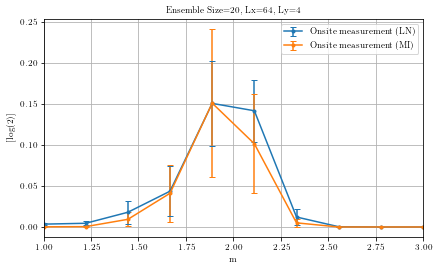

In [15]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'[log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
# fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_onsite_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## m=2

In [ ]:
# m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
# m_list=np.linspace(-4,4,40)
LN_Born_GS_list=[]
MI_Born_GS_list=[]
Lx,Ly=64,8

def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1,history=True)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link')
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    FN=params.fermion_number([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    return MI,LN,FN

In [ ]:
run((2,32,16))

## |GS>  in trivial regime |01>, m->inf

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
# m_list=np.linspace(-4,4,40)
LN_Born_GS_list=[]
MI_Born_GS_list=[]
Lx,Ly=64,32
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range=params.linearize_index([np.arange(params.Lx//4,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=2)
    prob_list=[1-(1-(-1)**i)/2 for i,x in enumerate(proj_range)]
    params.measure_all_Born(proj_range,type='onsite',prob=prob_list,linear=True)
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    LN=(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    return MI,LN
    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_GS_list.append(results[0])
    LN_Born_GS_list.append(results[1])


In [ ]:
fig,ax=plt.subplots()

ax.plot(m_list,LN_Born_GS_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_GS_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_GS_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## |GS>  in trivial regime |10>, m->-inf

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_GS2_list=[]
MI_Born_GS2_list=[]
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range=params.linearize_index([np.arange(params.Lx//4,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=2)
    prob_list=[(1-(-1)**i)/2 for i,x in enumerate(proj_range)]
    params.measure_all_Born(proj_range,type='onsite',prob=prob_list,linear=True)
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    LN=(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    return MI,LN
    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_GS2_list.append(results[0])
    LN_Born_GS2_list.append(results[1])


In [ ]:
fig,ax=plt.subplots()

ax.plot(m_list,LN_Born_GS2_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_GS2_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_GS2_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Link

In [ ]:
params=Params(m=1,Lx=64,Ly=8,bcx=-1,bcy=1,history=True)

In [ ]:
params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],type='link')

In [ ]:
[np.sum(np.array(params.s_history)==s) for s in ['o+','o-','e+','e-']]

In [ ]:
params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])/np.log(2)

In [ ]:
m_list=np.linspace(1,3,10)
# m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
es=1000
LN_Born_link_list=np.zeros((len(m_list),es))
MI_Born_link_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
outcome_Born_link_list=np.zeros((len(m_list),es,4))
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1,history=True)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link')
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    outcome=[np.sum(np.array(params.s_history)==s) for s in ['o+','o-','e+','e-']]
    return MI,LN,outcome
for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_link_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_link_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_list[m_i,index],LN_Born_link_list[m_i,index],outcome_Born_link_list[m_i,index,:]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
es,Lx,Ly=1000,64,8
# '/mnt/d/KITP/Rp_SPT/8/'
with open('/mnt/d/KITP/Rp_SPT/8/MI_LN_CI_Born_link_En{:d}_Lx{:d}_Ly{:d}.pickle'.format(es,Lx,Ly),'rb') as f:
    [m_list,MI_Born_link_list,LN_Born_link_list,outcome_Born_link_list,s_history_Born_link_list]=pickle.load(f)

In [ ]:
half_index=(outcome_Born_link_list@np.array([0,2,1,1]))==(Lx*Ly//4)
deviatefromhalf=(outcome_Born_link_list@np.array([0,2,1,1]))/(Lx*Ly//4)

In [ ]:
LN_Born_link_half_list=[LN_Born_link_list[i,j] for i,j in enumerate(half_index)]
MI_Born_link_half_list=[MI_Born_link_list[i,j] for i,j in enumerate(half_index)]

In [ ]:
LN_Born_link_half_list_ave=[np.mean(i) for i in LN_Born_link_half_list]
LN_Born_link_half_list_err=[np.std(i)/np.sqrt(es-1) for i in LN_Born_link_half_list]
MI_Born_link_half_list_ave=[np.mean(i) for i in MI_Born_link_half_list]
MI_Born_link_half_list_err=[np.std(i)/np.sqrt(es-1) for i in MI_Born_link_half_list]

In [ ]:
outcome_Born_link_list[-1,half_index[-1]].shape

In [ ]:
plt.plot(LN_Born_link_half_list_ave)
plt.plot(MI_Born_link_half_list_ave)

In [ ]:
fig,axs=plt.subplots(3,3,tight_layout=True,figsize=(6.8,6.8))
# ax.errorbar(m_list,LN_Born_link_list.mean(axis=1)/np.log(2),LN_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
# ax.errorbar(m_list,MI_Born_link_list.mean(axis=1)/np.log(2),MI_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

# ax.legend()
# ax.grid('on')
# ax.set_xlabel(r'm')
# ax.set_ylabel(r'log neg [log(2)]')
# ax.margins(x=0)
# ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))

axs[0,0].hist(deviatefromhalf[0],density=False,bins=20)
axs[0,1].hist(LN_Born_link_list[0]/np.log(2),density=False,bins=10)
axs[0,2].scatter(deviatefromhalf[0],LN_Born_link_list[0]/np.log(2),s=1)
axs[0,2].scatter(deviatefromhalf[0][half_index[0]],LN_Born_link_list[0][half_index[0]]/np.log(2),s=1)

axs[1,0].hist(deviatefromhalf[5],density=False,bins=20)
axs[1,1].hist(LN_Born_link_list[5]/np.log(2),density=False,bins=10)
axs[1,2].scatter(deviatefromhalf[5],LN_Born_link_list[5]/np.log(2),s=1)
axs[1,2].scatter(deviatefromhalf[5][half_index[5]],LN_Born_link_list[5][half_index[5]]/np.log(2),s=1)


axs[2,0].hist(deviatefromhalf[-1],density=False,bins=20)
axs[2,1].hist(LN_Born_link_list[-1]/np.log(2),density=False,bins=10)
axs[2,2].scatter(deviatefromhalf[-1],LN_Born_link_list[-1]/np.log(2),s=1)
axs[2,2].scatter(deviatefromhalf[-1][half_index[-1]],LN_Born_link_list[-1][half_index[-1]]/np.log(2),s=1)

[ax.set_title('$m={:.1f},L_x={:d},L_y={:d}$'.format(m_list[5],Lx,Ly)) for ax in axs[1]]
[ax.set_title('$m={:.1f},L_x={:d},L_y={:d}$'.format(m_list[-1],Lx,Ly)) for ax in axs[-1]]
[ax.set_title('$m={:.1f},L_x={:d},L_y={:d}$'.format(m_list[0],Lx,Ly)) for ax in axs[0]]

[ax.set_xlabel('Filling') for ax in axs[:,0]]
[ax.set_ylabel('Counts') for ax in axs[:,0]]
[ax.set_xlabel('LN [log 2]') for ax in axs[:,1]]
[ax.set_ylabel('Counts') for ax in axs[:,1]]
[ax.set_xlabel('Filling') for ax in axs[:,2]]
[ax.set_ylabel('LN [log 2]') for ax in axs[:,2]]

fig.savefig('/mnt/d/KITP/Rp_SPT/8/Correlation_Born_link_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(2,1,tight_layout=True,sharex=True)
ax=axs[0]
ax.errorbar(m_list,LN_Born_link_list.mean(axis=1)/np.log(2),LN_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_list.mean(axis=1)/np.log(2),MI_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')
ax.legend()
ax.grid('on')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}, [Original]'.format(es,Lx,Ly))

ax=axs[1]
ax.errorbar(m_list,LN_Born_link_half_list_ave/np.log(2),LN_Born_link_half_list_err/np.log(2),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_half_list_ave/np.log(2),MI_Born_link_half_list_err/np.log(2),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}, [Post-select half-filling]'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/CI_half_filling_Born_link_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [ ]:
plt.hist(deviatefromhalf[0],bins=25)

In [ ]:
plt.hist(LN_Born_link_list[5],density=True,bins=10)

In [ ]:
plt.scatter(deviatefromhalf[5],LN_Born_link_list[5])
plt.scatter(deviatefromhalf[5][half_index[5]],LN_Born_link_list[5][half_index[5]])
# plt.ylim([0,1])

In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_list.mean(axis=1)/np.log(2),LN_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_list.mean(axis=1)/np.log(2),MI_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
# fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [ ]:
outcome_Born_link_list.shape

In [ ]:
fig,ax=plt.subplots()
# labels = ['o+','o-','e+','e-']
labels=m_list
mean={'o+':outcome_Born_link_list[:,:,0].mean(axis=1)/(Lx*Ly//4),'o-':outcome_Born_link_list[:,:,1].mean(axis=1)/(Lx*Ly//4),'e+':outcome_Born_link_list[:,:,2].mean(axis=1)/(Lx*Ly//4),'e-':outcome_Born_link_list[:,:,3].mean(axis=1)/(Lx*Ly//4)}
std={'o+':outcome_Born_link_list[:,:,0].std(axis=1)/(Lx*Ly//4)/np.sqrt(es-1),'o-':outcome_Born_link_list[:,:,1].std(axis=1)/(Lx*Ly//4)/np.sqrt(es-1),'e+':outcome_Born_link_list[:,:,2].std(axis=1)/(Lx*Ly//4)/np.sqrt(es-1),'e-':outcome_Born_link_list[:,:,3].std(axis=1)/(Lx*Ly//4)/np.sqrt(es-1)}

ax.bar(labels,mean['o+'],0.05,label='o+',yerr=std['o+'])
ax.bar(labels,mean['o-'],0.05,bottom=mean['o+'],label='o-',yerr=std['o-'])
ax.bar(labels,mean['e+'],0.05,bottom=mean['o-']+mean['o+'],label='e+',yerr=std['e+'])
ax.bar(labels,mean['e-'],0.05,bottom=mean['o-']+mean['o+']+mean['e+'],label='e-',yerr=std['e-'])
ax.legend()
ax.set_xlabel('m')
ax.set_ylabel('Probability')
# fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_outcome_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link force to o+

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_list=[]
MI_Born_link_op_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',prob=[1,0,0,0])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_op_list.append(results[0])
    LN_Born_link_op_list.append(results[1])


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Link force to o-

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_om_list=[]
MI_Born_link_om_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',prob=[0,1,0,0])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_om_list.append(results[0])
    LN_Born_link_om_list.append(results[1])


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_om_list/np.log(2),'.-',label='Link (o-) measurement (LN)')
ax.plot(m_list,MI_Born_link_om_list/np.log(2),'.-',label='Link (o-) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_om_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Link force to e+

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_ep_list=[]
MI_Born_link_ep_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',prob=[0,0,1,0])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_ep_list.append(results[0])
    LN_Born_link_ep_list.append(results[1])


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_ep_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_ep_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_ep_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link, Born but with only {o+,o-}

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_pool2_list=np.zeros((len(m_list),es))
MI_Born_link_pool2_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',pool=2)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_pool2_list[m_i,index],LN_Born_link_pool2_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_pool2_list.mean(axis=1)/np.log(2),LN_Born_link_pool2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_pool2_list.mean(axis=1)/np.log(2),MI_Born_link_pool2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_pool2_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link, Born but with only {e+,e-}

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_poolm2_list=np.zeros((len(m_list),es))
MI_Born_link_poolm2_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',pool=-2)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_poolm2_list[m_i,index],LN_Born_link_poolm2_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_poolm2_list.mean(axis=1)/np.log(2),LN_Born_link_poolm2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_poolm2_list.mean(axis=1)/np.log(2),MI_Born_link_poolm2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_poolm2_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [ ]:
## see if there is a connected path ,and that fine

## all o+ but the last is e+

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_ep_list=[]
MI_Born_link_op_ep_list=[]
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0[:-1],type='link',prob=[1,0,0,0],linear=True)
    params.measure_all_Born(proj_range_0[-1:],type='link',prob=[0,0,1,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))
# async_result=(map(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_op_ep_list.append(results[0])
    LN_Born_link_op_ep_list.append(results[1])


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## all o+ but the middle is e+

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_ep_middle_list=[]
MI_Born_link_op_ep_middle_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0[:len(proj_range_0)//2],type='link',prob=[1,0,0,0],linear=True)
    params.measure_all_Born(proj_range_0[len(proj_range_0)//2:len(proj_range_0)//2+1],type='link',prob=[0,0,1,0],linear=True)
    params.measure_all_Born(proj_range_0[len(proj_range_0)//2+1:],type='link',prob=[1,0,0,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
# async_result=(rc[:].map_sync(run,inputs))
async_result=(map(run,inputs))


for index,results in enumerate(async_result):
    MI_Born_link_op_ep_middle_list.append(results[0])
    LN_Born_link_op_ep_middle_list.append(results[1])



In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_middle_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_middle_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_middle_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## one chain of Ly is o+, others are e+

## one ring is {o+,o-}, in between {e+,e-}

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_pool22_list=np.zeros((len(m_list),es))
MI_Born_link_pool22_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',pool=2,linear=True)
    params.measure_all_Born(proj_range_1,type='link',pool=-2,linear=True)
    params.measure_all_Born(proj_range_2,type='link',pool=2,linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_pool22_list[m_i,index],LN_Born_link_pool22_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_pool22_list.mean(axis=1)/np.log(2),LN_Born_link_pool22_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_pool22_list.mean(axis=1)/np.log(2),MI_Born_link_pool22_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_pool22_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## one ring is {o+,o-}, in between no measurement

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_pool2no2_list=np.zeros((len(m_list),es))
MI_Born_link_pool2no2_list=np.zeros((len(m_list),es))
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',pool=2,linear=True)
    # params.measure_all_Born(proj_range_1,type='link',pool=-2,linear=True)
    params.measure_all_Born(proj_range_2,type='link',pool=2,linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_pool2no2_list[m_i,index],LN_Born_link_pool2no2_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_pool2no2_list.mean(axis=1)/np.log(2),LN_Born_link_pool2no2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_pool2no2_list.mean(axis=1)/np.log(2),MI_Born_link_pool2no2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_pool2no2_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## one ring is o+, in between Born

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_op_ep_ring_middle_list=np.zeros((len(m_list),es))
MI_Born_link_op_ep_ring_middle_list=np.zeros((len(m_list),es))
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',prob=[1,0,0,0],linear=True)
    params.measure_all_Born(proj_range_1,type='link',pool=-2,linear=True)
    params.measure_all_Born(proj_range_2,type='link',prob=[1,0,0,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_op_ep_ring_middle_list[m_i,index],LN_Born_link_op_ep_ring_middle_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_ring_middle_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_ring_middle_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_ring_middle_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## one ring is o+, in between no measure

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_ep_ring_middle_no_list=[]
MI_Born_link_op_ep_ring_middle_no_list=[]
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',prob=[1,0,0,0],linear=True)
    # params.measure_all_Born(proj_range_1,type='link',prob=[0,0,1,0],linear=True)
    params.measure_all_Born(proj_range_2,type='link',prob=[1,0,0,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_op_ep_ring_middle_no_list.append(results[0])
    LN_Born_link_op_ep_ring_middle_no_list.append(results[1])


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_ring_middle_no_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_ring_middle_no_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_ring_middle_no_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## ignore symmetry, use four bell states

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_nosymm_list=np.zeros((len(m_list),es))
MI_Born_link_nosymm_list=np.zeros((len(m_list),es))
FN_Born_link_nosymm_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',linear=True,ignore=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    FN=params.fermion_number()
    return MI,LN,FN

for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_nosymm_list[m_i,index],LN_Born_link_nosymm_list[m_i,index],FN_Born_link_nosymm_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_nosymm_list.mean(axis=1)/np.log(2),LN_Born_link_nosymm_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_nosymm_list.mean(axis=1)/np.log(2),MI_Born_link_nosymm_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

# ax.errorbar(m_list,FN_Born_link_nosymm_list.mean(axis=1)/np.log(2),FN_Born_link_nosymm_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (Fermion number)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))

# ax2=ax.twinx()
# ax2.errorbar(m_list,FN_Born_link_nosymm_list.mean(axis=1),FN_Born_link_nosymm_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (Fermion number)',color='g')

# ax2.axhline(y=128*4,ls='--')
# ax2.set_ylabel('fermion number')
# # ax2.set_ylim([500,514])

fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_nosymm_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Inf onsite

In [ ]:
m_list=np.linspace(1,3,10)
es=20
LN_Born_inf_list=np.zeros((len(m_list),es))
MI_Born_inf_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_inf_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_inf_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_inf_list[m_i,index],LN_Born_inf_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_inf_list,'.-',label='No measurement (LN)')
# ax.plot(m_list,MI_no_inf_list,'.-',label='No measurement (MI)')

ax.errorbar(m_list,LN_Born_inf_list.mean(axis=1)/np.log(2),LN_Born_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_inf_list.mean(axis=1)/np.log(2),MI_Born_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')
ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, dx={:d}, dy={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_inf_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Inf link

In [ ]:
m_list=np.linspace(1,3,10)
es=20
LN_Born_link_inf_list=np.zeros((len(m_list),es))
MI_Born_link_inf_list=np.zeros((len(m_list),es))
Lx,Ly=64,8
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link')
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_link_inf_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_link_inf_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_inf_list[m_i,index],LN_Born_link_inf_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


In [ ]:
fig,ax=plt.subplots()
ax.errorbar(m_list,LN_Born_link_inf_list.mean(axis=1)/np.log(2),LN_Born_link_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_inf_list.mean(axis=1)/np.log(2),MI_Born_link_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')
ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, dx={:d}, dy={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_inf_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')


# Scaling at m=2

## no measurement

In [ ]:
import matplotlib.patches as mpatches
def place_region(x,y,fig,ax,color='ybyk'):  
    # fig,ax=plt.subplots()
    arc=[mpatches.Arc((x,y),50,50,-theta,0,90,transform=None,ec=ec,lw=5) for theta,ec in zip(np.arange(4)*90,color)]
    [fig.artists.append(arc) for arc in arc]
    ax.text(x+25,y+25,r'$A$',transform=None,ha='center',va='center')
    ax.text(x+25,y-25,r'$A^\prime$',transform=None,ha='center',va='center')
    ax.text(x-25,y-25,r'$B$',transform=None,ha='center',va='center')
    ax.text(x-25,y+25,r'$B^\prime$',transform=None,ha='center',va='center')

In [ ]:
eta_no_list=[]
MI_no_list=[]
LN_no_list=[]
x_list=[]
L=32
params=Params(m=2,Lx=L,Ly=16)
for ii in range(500):
    print(ii)
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    while x in x_list:
        x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
        x=[0]+x
    x_list.append(x)
    eta=cross_ratio(x,L)
    eta_no_list.append(eta)
    subregionA=[np.arange(x[0],x[1]),np.arange(params.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params.Ly)]
    MI=params.mutual_information_m(subregionA,subregionB)    
    MI_no_list.append(MI)
    LN=params.log_neg(subregionA,subregionB)
    LN_no_list.append(LN)
eta_no_list=np.array(eta_no_list)
MI_no_list=np.array(MI_no_list)
LN_no_list=np.array(LN_no_list)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_no_list,MI_no_list,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_no_list,LN_no_list,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_no_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_no_list>1e-10)&((eta_no_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_no_list[mask_MI]),np.log(MI_no_list[mask_MI]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_no_list>1e-10)&((eta_no_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_no_list[mask_LN]),np.log(LN_no_list[mask_LN]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ykyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_no.pdf')

## Born measurement

In [ ]:
eta_Born_onsite_Ap_list=[]
MI_Born_onsite_Ap_list=[]
LN_Born_onsite_Ap_list=[]
# x_list=[]
# subregion_list=[]
es=50
L=16
params_init=Params(m=2,Lx=L,Ly=8)

for _ in range(200):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=[np.arange(x[0],x[1]),np.arange(params_init.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params_init.Ly)]
    subregionAp=[np.arange(x[1],x[2]),np.arange(params_init.Ly)]
    eta=cross_ratio(x,L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_Ap_list.append(eta)
    MI_Born_onsite_Ap_list.append(MI_ensemble_list)
    LN_Born_onsite_Ap_list.append(LN_ensemble_list)
eta_Born_onsite_Ap_list=np.array(eta_Born_onsite_Ap_list)
MI_Born_onsite_Ap_list=np.array(MI_Born_onsite_Ap_list)
LN_Born_onsite_Ap_list=np.array(LN_Born_onsite_Ap_list)

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/8/MI_LN_CI_Born_En100_pts200_Lx32_Ly16_Ap.pickle','rb') as f:
    [eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list,LN_Born_onsite_Ap_list]=pickle.load(f)

In [ ]:
MI_Born_onsite_Ap_list_mean=MI_Born_onsite_Ap_list.mean(axis=1)
LN_Born_onsite_Ap_list_mean=LN_Born_onsite_Ap_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list_mean,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_Born_onsite_Ap_list,LN_Born_onsite_Ap_list_mean,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_Ap_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_MI]),np.log(MI_Born_onsite_Ap_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_LN]),np.log(LN_Born_onsite_Ap_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ycyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_Born_onsite_Ap.pdf')


In [ ]:
eta_Born_onsite_ApBp_list=[]
MI_Born_onsite_ApBp_list=[]
LN_Born_onsite_ApBp_list=[]
# x_list=[]
# subregion_list=[]
es=50
L=32
params_init=Params(m=2,Lx=L,Ly=8)

for _ in range(200):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=[np.arange(x[0],x[1]),np.arange(params_init.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params_init.Ly)]
    subregionAp=[np.arange(x[1],x[2]),np.arange(params_init.Ly)]
    subregionBp=[np.arange(x[3],L),np.arange(params_init.Ly)]
    eta=cross_ratio(x,L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_ApBp_list.append(eta)
    MI_Born_onsite_ApBp_list.append(MI_ensemble_list)
    LN_Born_onsite_ApBp_list.append(LN_ensemble_list)
eta_Born_onsite_ApBp_list=np.array(eta_Born_onsite_ApBp_list)
MI_Born_onsite_ApBp_list=np.array(MI_Born_onsite_ApBp_list)
LN_Born_onsite_ApBp_list=np.array(LN_Born_onsite_ApBp_list)

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/8/MI_LN_CI_Born_En100_pts200_Lx32_Ly16_ApBp.pickle','rb') as f:
    [eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list,LN_Born_onsite_Ap_list]=pickle.load(f)

In [ ]:
MI_Born_onsite_ApBp_list_mean=MI_Born_onsite_ApBp_list.mean(axis=1)
LN_Born_onsite_ApBp_list_mean=LN_Born_onsite_ApBp_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_ApBp_list,MI_Born_onsite_ApBp_list_mean,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_Born_onsite_ApBp_list,LN_Born_onsite_ApBp_list_mean,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_ApBp_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_MI]),np.log(MI_Born_onsite_ApBp_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_LN]),np.log(LN_Born_onsite_ApBp_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_Born_onsite_ApBp.pdf')


# Check area law of EE

In [ ]:
EE_list={}

In [ ]:
l_EE_list=np.arange(2,32)
for Ly in (8,12,16):
    params=Params(m=1,Lx=32,Ly=Ly)
    EE_list[Ly]=[(params.von_Neumann_entropy_f([np.arange(l),np.arange(params.Ly)])) for l in l_EE_list]


In [ ]:
fig,ax=plt.subplots()
for Ly in (8,12,16):
    ax.plot(l_EE_list,EE_list[Ly]/np.log(2),'.',label='Ly={:.1f}'.format(Ly))
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('EE [log 2]')
ax.legend()

In [ ]:
fig,ax=plt.subplots()
for Ly in (8,12,16):
    ax.plot(l_EE_list,EE_list[Ly]/np.log(2),'.',label='Ly={:.1f}'.format(Ly))
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('EE [log 2]')
ax.legend()

# LN scaling behavior

In [ ]:
LN_scaling_list={}

## fix dist, |A|_x, increase |A|_y

In [ ]:
LN_Ay={}

In [ ]:
Ly_list=np.arange(1,16)
Lx=32
LN_Ay=[Params(m=1,Lx=Lx,Ly=Ly).log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)]) for Ly in Ly_list]


In [ ]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_Ay/np.log(2),'.',label=r'$L_x={:d}$'.format(Lx),color='b')
ax.set_xlabel(r'$L_y$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Ly_list,LN_Ay/np.log(2))
xfit=Ly_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:e}~$L_y$+ {:e}'.format(lr.slope,lr.intercept))

ax.legend()

fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_Ay.pdf',bbox_inches='tight')

## fix dist, |A|_y, increase |A|_x

In [ ]:
Lx_list=np.arange(8,20)
Ly=32
dist=8
LN_Ax=[]

def run(p):
    Lx,Ly,dist=p
    return Params(m=0,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)])

inputs=[(Lx,Ly,dist) for Lx in Lx_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    LN_Ax.append(results)

In [ ]:
Lx_list=np.arange(2,20)
Ly=32
dist=8
LN_Ax=[Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for Lx in Lx_list]


In [ ]:
fig,ax=plt.subplots()
ax.plot(Lx_list,LN_Ax/np.log(2),'.',label=r'$L_y={:d}$'.format(Ly),color='b')
ax.set_xlabel(r'$A_x$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Lx_list,LN_Ax/np.log(2))
xfit=Lx_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:e}~$L_x$+ {:e}'.format(lr.slope,lr.intercept))

ax.legend()

fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_Ax.pdf',bbox_inches='tight')

## fix |A|_x, |A|_y, increase dist 

In [ ]:
dist_list=np.arange(2,16)
Lx=32
Ly=4
dist=8
# LN_dist=[Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for dist in dist_list]
LN_dist=[]
for dist in dist_list:
    st=time.time()
    LN_dist.append(Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]))
    print("{:d}:{:.2f}".format(dist,time.time()-st))
    with open('dist.pickle','wb') as f:
        pickle.dump([dist_list,LN_dist],f)

In [ ]:
dist_list=np.array(dist_list)
LN_dist=np.array(LN_dist)
fig,ax=plt.subplots(3,1,figsize=(6.8,8),tight_layout=True)
ax[0].plot((dist_list),(LN_dist/np.log(2)),'.')
ax[0].set_title('Linear(x)-Linear(y)')
ax[1].plot((dist_list),(LN_dist/np.log(2)),'.')
ax[1].set_yscale('log')
ax[1].set_title('Linear(x)-Log(y)')

ax[2].plot((dist_list),(LN_dist/np.log(2)),'.')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Log(x)-Log(y)')

ax[-1].set_xlabel(r'$A^\prime_x$')
[ax.set_ylabel(r'LN [log 2]') for ax in ax]

mask=dist_list<10
lr=scipy.stats.linregress((dist_list[mask]),np.log(LN_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[1].plot(xfit,np.exp(lr.slope*xfit+lr.intercept),'c',label=r'LN=exp({:.4f}~d+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))
ax[1].legend()
mask=dist_list<10
lr=scipy.stats.linregress(np.log(dist_list[mask]),np.log(LN_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[2].plot(xfit,np.exp(lr.slope*np.log(xfit)+lr.intercept),'c',label=r'LN=exp({:.4f}~log(d)+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))# ax[0].legend()
ax[2].legend()

fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_dist.pdf',bbox_inches='tight')

In [ ]:
plt.plot(xfit,np.exp(lr.slope*xfit+lr.intercept))

In [ ]:
lr.rvalue

In [ ]:
fig,ax=plt.subplots()
ax.plot(dist_list,LN_dist,'.')
# ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
Ly_list=np.arange(2,16)
Lx_list=np.arange(2,8)
LN_scaling_list=np.zeros((Lx_list.shape[0],Ly_list.shape[0]))
for Ly_i,Ly in enumerate(Ly_list):
    for Lx_i,Lx in enumerate(Lx_list):
        params=Params(m=1,Lx=4*Lx,Ly=Ly)
        LN_scaling_list[Lx_i,Ly_i]=params.log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+2*Lx,np.arange(Ly)])


In [ ]:
Lx_map,Ly_map=np.meshgrid(Lx_list,Ly_list)

In [ ]:
plt.plot()

In [ ]:
plt.plot((Ly_map/Lx_map).flatten(),LN_scaling_list.flatten(),'.')

In [ ]:
fig,ax=plt.subplots()
for Ly_i,Ly in enumerate(Ly_list):
    ax.plot(Lx_list,LN_scaling_list[:,Ly_i],'.-',label='Ly={:d}'.format(Ly))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_xlabel('$L_x$')
ax.set_ylabel('log neg')

In [ ]:
fig,ax=plt.subplots()
for Ly_i,Ly in enumerate(Ly_list):
    ax.plot(Lx_list,LN_scaling_list[:,Ly_i],'.-',label='Ly={:d}'.format(Ly))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_xlabel('$L_x$')
ax.set_ylabel('log neg')

In [ ]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_scaling_list[1,:])
ax.plot(Ly_list,LN_scaling_list[2,:])
ax.plot(Ly_list,LN_scaling_list[3,:])
ax.plot(Ly_list,LN_scaling_list[4,:])
ax.plot(Ly_list,LN_scaling_list[5,:])
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
l_LN_list=np.arange(2,8)
for Ly in (8,12,16):
    LN_scaling_list[Ly]=[]
    for Lx in l_LN_list:
        params=Params(m=1,Lx=4*Lx,Ly=Ly)
        LN_scaling_list[Ly].append(params.log_neg([np.arange(Lx),np.arange(params.Ly)],[np.arange(Lx)+2*Lx,np.arange(params.Ly)]))

In [ ]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(np.log(l_LN_list),np.log(v/np.log(2)),'.',label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

In [ ]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

In [ ]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

### Scaling of states to the GS

In [ ]:
m,Lx=1,64
# '/mnt/d/KITP/Rp_SPT/8/'
with open('/mnt/d/KITP/Rp_SPT/8/CI_scaling_m{:d}_Lx{:d}.pickle'.format(m,Lx),'rb') as f:
    [Ly_list,MI_Born_scaling_list,LN_Born_scaling_list]=pickle.load(f)

In [ ]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_Born_scaling_list/np.log(2),'.-',label='Onsite measurement (LN)')
ax.plot(Ly_list,MI_Born_scaling_list/np.log(2),'.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
# ax.set_yticks([0,0.5,1])
ax.set_xlabel(r'$L_y$')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, m={:d}'.format(Lx,m))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/CI_scaling_m{:d}_Lx{:d}.pdf'.format(m,Lx),bbox_inches='tight')

## Infinite 

## fix dist, |A|_x, increase |A|_y

In [ ]:
LN_Ay={}

In [ ]:
Ly_list=np.arange(2,32)
Lx=8
LN_inf_Ay=[Params(m=1,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf).log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)]) for Ly in Ly_list]


In [ ]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_inf_Ay/np.log(2),'.',label=r'$L_x={:d}$'.format(Lx),color='b')
ax.set_xlabel(r'$L_y$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Ly_list,LN_inf_Ay/np.log(2))
xfit=Ly_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:.4f}~$L_y$+ {:.4f}'.format(lr.slope,lr.intercept))

ax.legend()

fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_inf_Ay.pdf',bbox_inches='tight')

## fix dist, |A|_y, increase |A|_x

In [ ]:
Lx_list=np.arange(2,20)
Ly=32
dist=8
LN_inf_Ax=[Params(m=1,dxmax=2*Lx+2*dist,dymax=Ly,Lx=np.inf,Ly=np.inf).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for Lx in Lx_list]


In [ ]:
fig,ax=plt.subplots()
ax.plot(Lx_list,LN_inf_Ax/np.log(2),'.',label=r'$L_y={:d}$'.format(Ly),color='b')
ax.set_xlabel(r'$A_x$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Lx_list,LN_inf_Ax/np.log(2))
xfit=Lx_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:e}~$L_x$+ {:e}'.format(lr.slope,lr.intercept))

ax.legend()

fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_inf_Ax.pdf',bbox_inches='tight')

## fix |A|_x, |A|_y, increase dist 

In [ ]:
dist_list=np.arange(2,16)
Lx=8
Ly=32
dist=8
# LN_inf_dist=[Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for dist in dist_list]
LN_inf_dist=[]
for dist in dist_list:
    st=time.time()
    LN_inf_dist.append(Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]))
    print("{:d}:{:.2f}".format(dist,time.time()-st))
    # with open('dist.pickle','wb') as f:
    #     pickle.dump([dist_list,LN_inf_dist],f)

In [ ]:
dist_list=np.array(dist_list)
LN_inf_dist=np.array(LN_inf_dist)
fig,ax=plt.subplots(3,1,figsize=(6.8,8),tight_layout=True)
ax[0].plot((dist_list),(LN_inf_dist/np.log(2)),'.')
ax[0].set_title('Linear(x)-Linear(y)')
ax[1].plot((dist_list),(LN_inf_dist/np.log(2)),'.')
ax[1].set_yscale('log')
ax[1].set_title('Linear(x)-Log(y)')

ax[2].plot((dist_list),(LN_inf_dist/np.log(2)),'.')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Log(x)-Log(y)')

ax[-1].set_xlabel(r'$A^\prime_x$')
[ax.set_ylabel(r'LN [log 2]') for ax in ax]

mask=dist_list<10
lr=scipy.stats.linregress((dist_list[mask]),np.log(LN_inf_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[1].plot(xfit,np.exp(lr.slope*xfit+lr.intercept),'c',label=r'LN=exp({:.4f}~d+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))
ax[1].legend()
mask=dist_list<10
lr=scipy.stats.linregress(np.log(dist_list[mask]),np.log(LN_inf_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[2].plot(xfit,np.exp(lr.slope*np.log(xfit)+lr.intercept),'c',label=r'LN=exp({:.4f}~log(d)+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))# ax[0].legend()
ax[2].legend()

fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_inf_dist.pdf',bbox_inches='tight')

# Measurement based on geometry


## A inside A' inside B

In [123]:
Lx,Ly=16,16
params=Params(m=1,Lx=Lx,Ly=Ly)

In [128]:
proj_total_A=params.linearize_index([np.arange(params.Lx//8*3,params.Lx//8*5),np.arange(params.Ly//8*3,params.Ly//8*5)],4,proj=True,k=2)
proj_total_A_Ap=params.linearize_index([np.arange(params.Lx//4,params.Lx//4*3),np.arange(params.Ly//4,params.Ly//4*3)],4,proj=True,k=2)
proj_total_Ap=np.setdiff1d(proj_total_A_Ap,proj_total_A)

sub_A=params.linearize_index([np.arange(params.Lx//8*3,params.Lx//8*5),np.arange(params.Ly//8*3,params.Ly//8*5)],4)
sub_A_Ap=params.linearize_index([np.arange(params.Lx//4,params.Lx//4*3),np.arange(params.Ly//4,params.Ly//4*3)],4)
sub_A_Ap_B=params.linearize_index([np.arange(params.Lx//8,params.Lx//8*7),np.arange(params.Ly//8,params.Ly//8*7)],4)
sub_B=np.setdiff1d(sub_A_Ap_B,sub_A_Ap)

# poke a hole
sub_A0=params.linearize_index([np.arange(params.Lx//16*7,params.Lx//16*9),np.arange(params.Ly//16*7,params.Ly//16*9)],4)
sub_A=np.setdiff1d(sub_A,sub_A0)

In [129]:
proj_total_Ap.shape

(96,)

(0.0, 15.0)

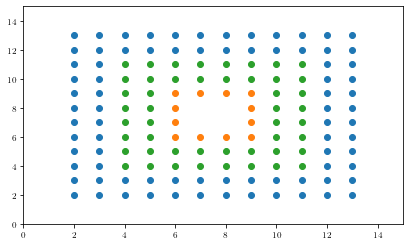

In [130]:
fig,ax=plt.subplots()

ix,iy=params.square_index(sub_B)
ax.scatter(ix,iy)

ix,iy=params.square_index(sub_A)
ax.scatter(ix,iy)

ix,iy=params.square_index(proj_total_Ap)
ax.scatter(ix,iy)
ax.set_xlim([0,Lx-1])
ax.set_ylim([0,Ly-1])

In [173]:
def run(inputs):
    Lx,Ly,m=inputs
    # Lx,Ly,m,bcx,bcy=inputs
    bcx=0
    bcy=0
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=bcx,bcy=bcy)
    proj_total_A=params.linearize_index([np.arange(params.Lx//8*3,params.Lx//8*5),np.arange(params.Ly//8*3,params.Ly//8*5)],4,proj=True,k=4)
    proj_total_A_Ap=params.linearize_index([np.arange(params.Lx//4,params.Lx//4*3),np.arange(params.Ly//4,params.Ly//4*3)],4,proj=True,k=4)
    proj_total_Ap=np.setdiff1d(proj_total_A_Ap,proj_total_A)

    sub_A=params.linearize_index([np.arange(params.Lx//8*3,params.Lx//8*5),np.arange(params.Ly//8*3,params.Ly//8*5)],4)
    sub_A_Ap=params.linearize_index([np.arange(params.Lx//4,params.Lx//4*3),np.arange(params.Ly//4,params.Ly//4*3)],4)
    sub_A_Ap_B=params.linearize_index([np.arange(params.Lx//8,params.Lx//8*7),np.arange(params.Ly//8,params.Ly//8*7)],4)
    sub_B=np.setdiff1d(sub_A_Ap_B,sub_A_Ap)
    #poke a hole
    sub_A0=params.linearize_index([np.arange(params.Lx//16*7,params.Lx//16*9),np.arange(params.Ly//16*7,params.Ly//16*9)],4)
    sub_A=np.setdiff1d(sub_A,sub_A0)
    
    # ,bcx=1,bcy=1
    # params.measure_all_Born(proj_total_Ap,linear=True,type='correlated')
    params.measure_all_Born(proj_total_Ap,linear=True,type='correlated',prob=[1,0])
    return params.log_neg(sub_A,sub_B,linear=True)

In [172]:
run((16,16,1))

3.174396283431312

In [83]:
pool=rc[:].map_

In [139]:
m_list=np.linspace(1,3,6)
# m_list=[1,2,3]

es=1
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))

LN_list=np.zeros((len(m_list),es))
Lx=16
Ly=16
for m_i,m in enumerate(m_list):
    inputs=[(Lx,Ly,m) for _ in range(es)]
    pool=(rc[:].map_sync(run,inputs))
    for es_i,result in enumerate(pool):
        LN=result
        LN_list[m_i,es_i]=LN

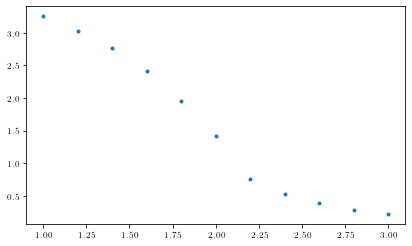

In [141]:
plt.plot(m_list,LN_list.mean(axis=1),'.')

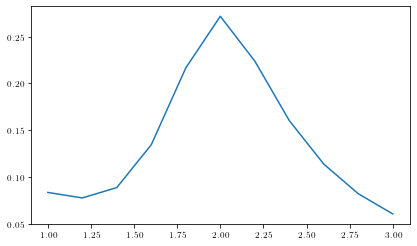

In [70]:
plt.plot(m_list,LN_list.mean(axis=1))

In [165]:
def run2(Lx,Ly):
    m_list=np.linspace(1,3,6)

    es=1
    LN_Born_list=np.zeros((len(m_list),es))
    MI_Born_list=np.zeros((len(m_list),es))

    LN_list=np.zeros((len(m_list),es))
    for m_i,m in enumerate(m_list):
        inputs=[(Lx,Ly,m) for _ in range(es)]
        pool=(rc[:].map_sync(run,inputs))
        for es_i,result in enumerate(pool):
            LN=result
            LN_list[m_i,es_i]=LN
    return LN_list

In [7]:
def run2_es(Lx,Ly,es):
    m_list=np.linspace(1,3,6)

    # es=1
    LN_Born_list=np.zeros((len(m_list),es))
    MI_Born_list=np.zeros((len(m_list),es))

    LN_list=np.zeros((len(m_list),es))
    for m_i,m in enumerate(m_list):
        inputs=[(Lx,Ly,m) for _ in range(es)]
        pool=(rc[:].map_sync(run,inputs))
        for es_i,result in enumerate(pool):
            LN=result
            LN_list[m_i,es_i]=LN
    return LN_list

In [166]:
LN_16_16_list=run2(16,16)

In [8]:
LN_16_16_20_list=run2_es(16,16,20)

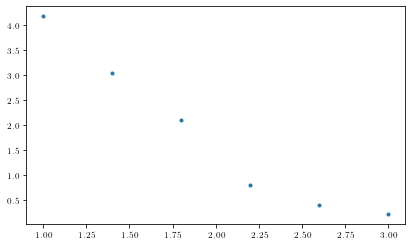

In [12]:
plt.plot(m_list,LN_16_16_20_list.mean(axis=1),'.')

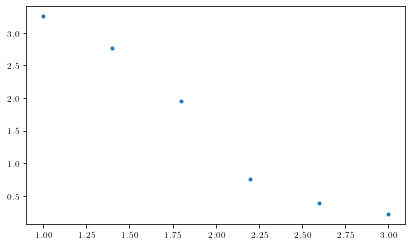

In [ ]:
plt.plot(m_list,LN_16_16_list,'.')

In [168]:
LN_24_24_list=run2(24,24)

In [13]:
LN_24_24_20_list=run2_es(24,24,20)

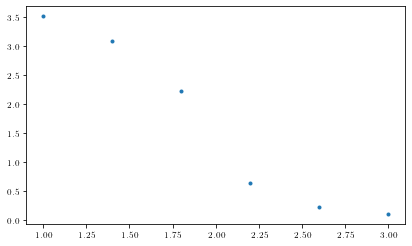

In [170]:
plt.plot(m_list,LN_24_24_list,'.')

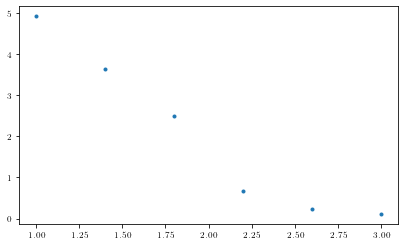

In [14]:
plt.plot(m_list,LN_24_24_20_list.mean(axis=1),'.')

In [156]:
LN_16_8_list=run2(16,8)

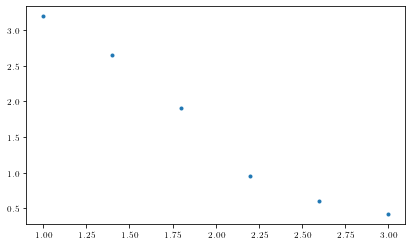

In [158]:
plt.plot(m_list,LN_16_8_list,'.')

In [159]:
LN_24_8_list=run2(24,8)

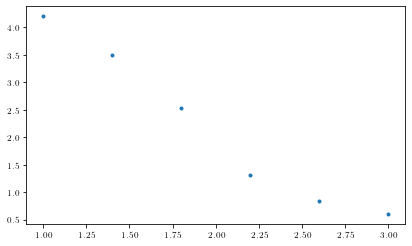

In [160]:
plt.plot(m_list,LN_24_8_list,'.')

In [161]:
LN_32_32_list=run2(32,32)

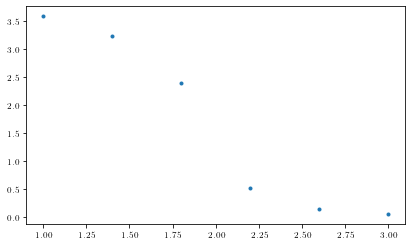

In [162]:
plt.plot(m_list,LN_32_32_list,'.')

##  A // B inside C

In [ ]:
Lx,Ly=32,16
params=Params(m=1,Lx=Lx,Ly=Ly)

In [ ]:
proj_total_A=params.linearize_index([np.arange(params.Lx//8,params.Lx//8*3),np.arange(params.Ly//4,params.Ly//2)],4,proj=True,k=4)
proj_total_B=params.linearize_index([np.arange(params.Lx//8*5,params.Lx//8*7),np.arange(params.Ly//4,params.Ly//2)],4,proj=True,k=4)
proj_total_Ap_A_B=params.linearize_index([np.arange(0,params.Lx),np.arange(0,params.Ly//4*3)],4,proj=True,k=4)
proj_total_Ap=np.setdiff1d(proj_total_Ap_A_B,np.hstack((proj_total_A,proj_total_B)))

sub_A=params.linearize_index([np.arange(params.Lx//8,params.Lx//8*3),np.arange(params.Ly//4,params.Ly//2)],4)
sub_B=params.linearize_index([np.arange(params.Lx//8*5,params.Lx//8*7),np.arange(params.Ly//4,params.Ly//2)],4)

In [ ]:
fig,ax=plt.subplots()

ix,iy=params.square_index(sub_B)
ax.scatter(ix,iy)

ix,iy=params.square_index(sub_A)
ax.scatter(ix,iy)

ix,iy=params.square_index(proj_total_Ap)
ax.scatter(ix,iy)
ax.set_xlim([0,Lx-1])
ax.set_ylim([0,Ly-1])

In [77]:
def run(inputs):
    Lx,Ly,m=inputs
    # Lx,Ly,m,bcx,bcy=inputs
    bcx=1
    bcy=1
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=bcx,bcy=bcy)
    proj_total_A=params.linearize_index([np.arange(params.Lx//8,params.Lx//8*3),np.arange(params.Ly//4,params.Ly//2)],4,proj=True,k=4)
    proj_total_B=params.linearize_index([np.arange(params.Lx//8*5,params.Lx//8*7),np.arange(params.Ly//4,params.Ly//2)],4,proj=True,k=4)
    proj_total_Ap_A_B=params.linearize_index([np.arange(0,params.Lx),np.arange(0,params.Ly//4*3)],4,proj=True,k=4)
    proj_total_Ap=np.setdiff1d(proj_total_Ap_A_B,np.hstack((proj_total_A,proj_total_B)))

    sub_A=params.linearize_index([np.arange(params.Lx//8,params.Lx//8*3),np.arange(params.Ly//4,params.Ly//2)],4)
    sub_B=params.linearize_index([np.arange(params.Lx//8*5,params.Lx//8*7),np.arange(params.Ly//4,params.Ly//2)],4)
    
    # ,bcx=1,bcy=1
    # params.measure_all_Born(proj_total_Ap,linear=True,type='correlated')
    params.measure_all_Born(proj_total_Ap,linear=True,type='correlated',prob=[1,0])

    return params.log_neg(sub_A,sub_B,linear=True)

In [79]:
run((32,16,1))

0.2640355317503018

In [ ]:
m_list=np.linspace(1,3,11)
# m_list=[1,2,3]

es=10
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))

LN_list=np.zeros((len(m_list),es))
Lx=32
Ly=16
for m_i,m in enumerate(m_list):
    inputs=[(Lx,Ly,m) for _ in range(es)]
    pool=(rc[:].map_sync(run,inputs))
    for es_i,result in enumerate(pool):
        LN=result
        LN_list[m_i,es_i]=LN

In [ ]:
plt.plot(m_list,LN_list.mean(axis=1),'.')

## load from pickle

### A in A' in B

In [6]:
m_Born_g1_list={}
MI_Born_g1_list={}
LN_Born_g1_list={}
m_Force_g1_list={}
MI_Force_g1_list={}
LN_Force_g1_list={}
m_g1_list={}
MI_g1_list={}
LN_g1_list={}

for Lx,Ly in zip([16,24,32],[16,24,32]):
    with open('/mnt/d/kitp/Rp_SPT/8/CI_Born_En30_Lx{:}_Ly{:}_geo1_Born.pickle'.format(Lx,Ly),'rb') as f:
        [m_Born_g1_list[(Lx,Ly)],MI_Born_g1_list[(Lx,Ly)],LN_Born_g1_list[(Lx,Ly)]]=pickle.load(f)
    with open('/mnt/d/kitp/Rp_SPT/8/CI_Born_En1_Lx{:}_Ly{:}_geo1_Force.pickle'.format(Lx,Ly),'rb') as f:
        [m_Force_g1_list[(Lx,Ly)],MI_Force_g1_list[(Lx,Ly)],LN_Force_g1_list[(Lx,Ly)]]=pickle.load(f)
    with open('/mnt/d/kitp/Rp_SPT/8/CI_Born_En1_Lx{:}_Ly{:}_geo1_.pickle'.format(Lx,Ly),'rb') as f:
        [m_g1_list[(Lx,Ly)],MI_g1_list[(Lx,Ly)],LN_g1_list[(Lx,Ly)]]=pickle.load(f)

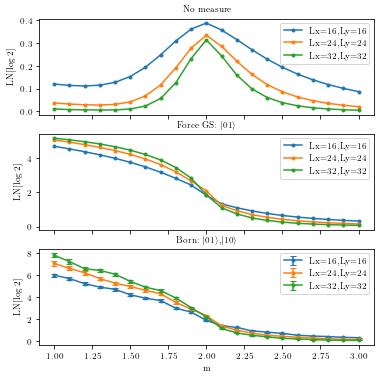

In [122]:
fig,axs=plt.subplots(3,1,figsize=(6,6),sharex=True)
ax=axs[0]
for Lx,Ly in zip([16,24,32],[16,24,32]):
    ax.plot(m_g1_list[(Lx,Ly)],LN_g1_list[(Lx,Ly)].mean(axis=1)/np.log(2),'.-',label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_ylabel('LN[log 2]')
ax.set_title('No measure')
ax=axs[1]
for Lx,Ly in zip([16,24,32],[16,24,32]):
    ax.plot(m_Force_g1_list[(Lx,Ly)],LN_Force_g1_list[(Lx,Ly)].mean(axis=1)/np.log(2),'.-',label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_ylabel('LN[log 2]')
ax.set_title(r'Force GS: $|01\rangle$')

ax=axs[2]
for Lx,Ly in zip([16,24,32],[16,24,32]):
    ax.errorbar(m_Born_g1_list[(Lx,Ly)],LN_Born_g1_list[(Lx,Ly)].mean(axis=1)/np.log(2),LN_Born_g1_list[(Lx,Ly)].std(axis=1)/np.sqrt(20)/np.log(2),fmt='.-',capsize=3,label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_title(r'Born: $|01\rangle$,$|10\rangle$')

ax.set_xlabel('m')
ax.set_ylabel('LN[log 2]')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/Geo1.pdf')

In [8]:
m_Force_g1_list={}
MI_Force_g1_list={}
LN_Force_g1_list={}

for Lx,Ly in zip([16,24,32,48,64],[16,24,32,48,64]):
    with open('/mnt/d/kitp/Rp_SPT/8/CI_Born_En1_Lx{:}_Ly{:}_geo1_Force.pickle'.format(Lx,Ly),'rb') as f:
        [m_Force_g1_list[(Lx,Ly)],MI_Force_g1_list[(Lx,Ly)],LN_Force_g1_list[(Lx,Ly)]]=pickle.load(f)

Text(0.5, 1.0, 'Force GS: $|01\\rangle$')

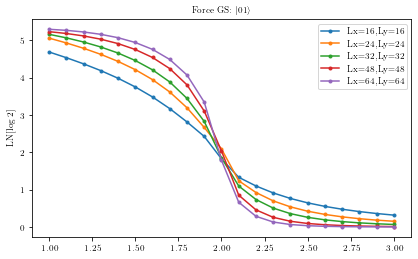

In [10]:
fig,ax=plt.subplots()
for Lx,Ly in zip([16,24,32,48,64],[16,24,32,48,64]):
    ax.plot(m_Force_g1_list[(Lx,Ly)],LN_Force_g1_list[(Lx,Ly)].mean(axis=1)/np.log(2),'.-',label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_ylabel('LN[log 2]')
ax.set_title(r'Force GS: $|01\rangle$')

In [41]:
(ln_m1_list.flatten())

array([3.25133863, 3.50846154, 3.57914904, 3.62836738, 3.67262138])

In [45]:
6*np.log(2)

4.1588830833596715

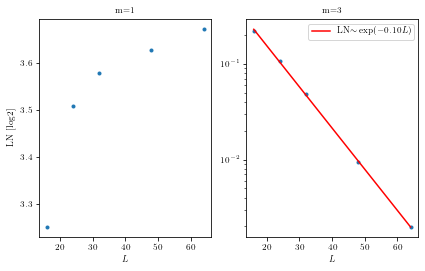

In [116]:
fig,axs=plt.subplots(1,2)
L_list=np.array([16,24,32,48,64])

ln_m1_list=np.array([LN_Force_g1_list[(Lx,Lx)][0] for Lx in L_list])
ln_m3_list=np.array([LN_Force_g1_list[(Lx,Lx)][-1] for Lx in L_list])

ax=axs[0]
ax.plot((L_list),ln_m1_list,'.')
# ax.set_xscale('log')
ax.set_title('m=1')
ax.set_ylabel('LN [log2]')
ax.set_xlabel('$L$')

ax=axs[1]
ax.plot(L_list,ln_m3_list,'.')
ax.set_yscale('log')
ax.set_xlabel('$L$')
ax.set_title('m=3')
lr=scipy.stats.linregress(L_list,np.log(ln_m3_list.flatten()))
ax.plot(L_list,np.exp(lr.slope*np.array(L_list)+lr.intercept),'r',label='LN$\sim \exp({:.2f}L)$'.format(lr.slope))
ax.legend()
fig.savefig('/mnt/d/KITP/Rp_SPT/8/Geo1_scaling.pdf')

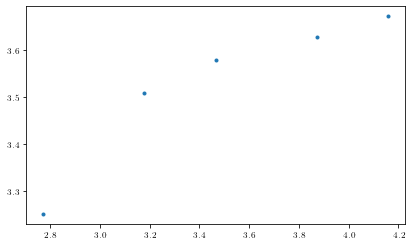

In [119]:
plt.plot(np.log(L_list),ln_m1_list,'.')


In [104]:
lr=scipy.stats.linregress(L_list,np.log(ln_m3_list))


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5 and the array at index 1 has size 1

In [86]:
x=np.linspace(16,64)
y=3*np.log(x)+1

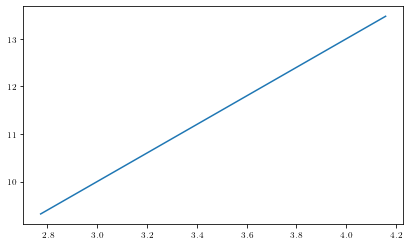

In [88]:
plt.plot(np.log(x),y)

In [ ]:
scipy.optimize.curve_fit(lambda )

In [71]:
x_list=np.linspace(3.687,3.689,11)
lr=[scipy.stats.linregress(L_list,np.log(x-ln_m1_list).flatten()) for x in x_list]

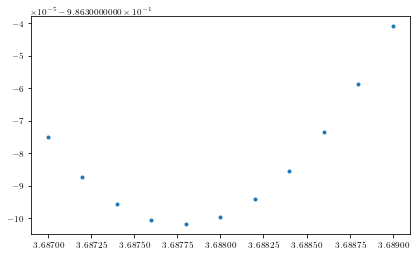

In [72]:
rsq_list=[lr.rvalue for lr in lr]
plt.plot(x_list,rsq_list,'.')

In [73]:
x_list[np.argmin(rsq_list)]

3.6877999999999997

In [24]:
np.exp(lr.intercept)

1.1171243966861173

### A // B in A'

In [13]:
m_Born_g2_list={}
MI_Born_g2_list={}
LN_Born_g2_list={}
m_Force_g2_list={}
MI_Force_g2_list={}
LN_Force_g2_list={}
m_g2_list={}
MI_g2_list={}
LN_g2_list={}

for Lx,Ly in zip([32,32,32],[16,24,32]):
    with open('/mnt/d/kitp/Rp_SPT/8/CI_Born_En30_Lx{:}_Ly{:}_geo2_Born.pickle'.format(Lx,Ly),'rb') as f:
        [m_Born_g2_list[(Lx,Ly)],MI_Born_g2_list[(Lx,Ly)],LN_Born_g2_list[(Lx,Ly)]]=pickle.load(f)
    with open('/mnt/d/kitp/Rp_SPT/8/CI_Born_En1_Lx{:}_Ly{:}_geo2_Force.pickle'.format(Lx,Ly),'rb') as f:
        [m_Force_g2_list[(Lx,Ly)],MI_Force_g2_list[(Lx,Ly)],LN_Force_g2_list[(Lx,Ly)]]=pickle.load(f)
    with open('/mnt/d/kitp/Rp_SPT/8/CI_Born_En1_Lx{:}_Ly{:}_geo2_.pickle'.format(Lx,Ly),'rb') as f:
        [m_g2_list[(Lx,Ly)],MI_g2_list[(Lx,Ly)],LN_g2_list[(Lx,Ly)]]=pickle.load(f)

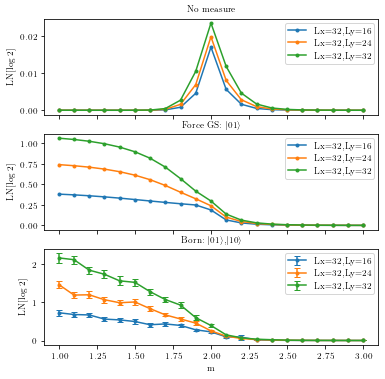

In [14]:
fig,axs=plt.subplots(3,1,figsize=(6,6),sharex=True)
ax=axs[0]
for Lx,Ly in zip([32,32,32],[16,24,32]):
    ax.plot(m_g2_list[(Lx,Ly)],LN_g2_list[(Lx,Ly)].mean(axis=1)/np.log(2),'.-',label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_ylabel('LN[log 2]')
ax.set_title('No measure')
ax=axs[1]
for Lx,Ly in zip([32,32,32],[16,24,32]):
    ax.plot(m_Force_g2_list[(Lx,Ly)],LN_Force_g2_list[(Lx,Ly)].mean(axis=1)/np.log(2),'.-',label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_ylabel('LN[log 2]')
ax.set_title(r'Force GS: $|01\rangle$')

ax=axs[2]
for Lx,Ly in zip([32,32,32],[16,24,32]):
    ax.errorbar(m_Born_g2_list[(Lx,Ly)],LN_Born_g2_list[(Lx,Ly)].mean(axis=1)/np.log(2),LN_Born_g2_list[(Lx,Ly)].std(axis=1)/np.sqrt(20)/np.log(2),fmt='.-',capsize=3,label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_title(r'Born: $|01\rangle$,$|10\rangle$')

ax.set_xlabel('m')
ax.set_ylabel('LN[log 2]')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/Geo2.pdf')

Text(0, 0.5, 'MI[log 2]')

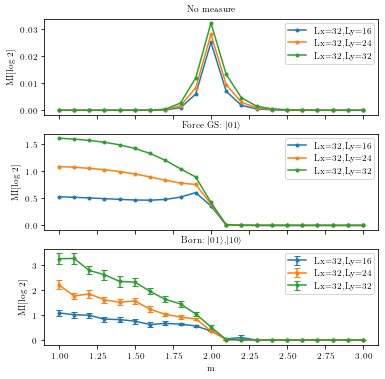

In [15]:
fig,axs=plt.subplots(3,1,figsize=(6,6),sharex=True)
ax=axs[0]
for Lx,Ly in zip([32,32,32],[16,24,32]):
    ax.plot(m_g2_list[(Lx,Ly)],MI_g2_list[(Lx,Ly)].mean(axis=1)/np.log(2),'.-',label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_ylabel('MI[log 2]')
ax.set_title('No measure')
ax=axs[1]
for Lx,Ly in zip([32,32,32],[16,24,32]):
    ax.plot(m_Force_g2_list[(Lx,Ly)],MI_Force_g2_list[(Lx,Ly)].mean(axis=1)/np.log(2),'.-',label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_ylabel('MI[log 2]')
ax.set_title(r'Force GS: $|01\rangle$')

ax=axs[2]
for Lx,Ly in zip([32,32,32],[16,24,32]):
    ax.errorbar(m_Born_g2_list[(Lx,Ly)],MI_Born_g2_list[(Lx,Ly)].mean(axis=1)/np.log(2),MI_Born_g2_list[(Lx,Ly)].std(axis=1)/np.sqrt(20)/np.log(2),fmt='.-',capsize=3,label='Lx={:},Ly={:}'.format(Lx,Ly))
ax.legend()
ax.set_title(r'Born: $|01\rangle$,$|10\rangle$')

ax.set_xlabel('m')
ax.set_ylabel('MI[log 2]')
# fig.savefig('/mnt/d/kitp/Rp_SPT/8/Geo2.pdf')

## genus (0,0) --a

In [46]:
params_g00_a=Params(m=1,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)

In [ ]:
proj_total_g00_a=params_g00_a.linearize_index([np.arange(params_g00_a.dxmax),np.arange(params_g00_a.dymax)],4,proj=True)
ax,ay=4,4
proj_A_g00_a=params_g00_a.linearize_index([np.arange(params_g00_a.dxmax//4-ax//2,params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4,proj=True)
proj_B_g00_a=params_g00_a.linearize_index([np.arange(3*params_g00_a.dxmax//4-ax//2,3*params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4,proj=True)
proj_range_g00_a=np.setdiff1d(proj_total_g00_a,np.union1d(proj_A_g00_a,proj_B_g00_a))
sub_A_g00_a=params_g00_a.linearize_index([np.arange(params_g00_a.dxmax//4-ax//2,params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4)
sub_B_g00_a=params_g00_a.linearize_index([np.arange(3*params_g00_a.dxmax//4-ax//2,3*params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g00_a.square_index(proj_total_g00_a),color='k')
ax.scatter(*params_g00_a.square_index(sub_A_g00_a),color='c')
ax.scatter(*params_g00_a.square_index(sub_B_g00_a),color='r')
ax.scatter(*params_g00_a.square_index(proj_range_g00_a),color='b')

In [ ]:
m_list_g00_a=np.linspace(1,3,20)
es_g00_a=50
LN_Born_inf_list_g00_a=np.zeros((len(m_list_g00_a),es_g00_a))
MI_Born_inf_list_g00_a=np.zeros((len(m_list_g00_a),es_g00_a))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g00_a=[]
for m_i,m in enumerate(m_list_g00_a):
    inputs=[(proj_range_g00_a,sub_A_g00_a,sub_B_g00_a,m) for _ in range(es_g00_a)]
    async_result_g00_a.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g00_a=[]
for m_i,m in enumerate(m_list_g00_a):
    st=time.time()
    LN_Born_inf_list_g00_a.append(async_result_g00_a[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g00_a=np.array(LN_Born_inf_list_g00_a)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g00_a.square_index(proj_total_g00_a),color='k')
ax[0].scatter(*params_g00_a.square_index(sub_A_g00_a),color='c')
ax[0].scatter(*params_g00_a.square_index(sub_B_g00_a),color='r')
ax[0].scatter(*params_g00_a.square_index(proj_range_g00_a),color='b')
ax[1].errorbar(m_list_g00_a,LN_Born_inf_list_g00_a.mean(axis=1),LN_Born_inf_list_g00_a.std(axis=1)/np.sqrt(es_g00_a-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_inf_g00_a.pdf')

## geneus (0,1) --a

In [ ]:
params_g01_a=Params(m=1,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)

In [ ]:
proj_total_g01_a=params_g01_a.linearize_index([np.arange(params_g01_a.dxmax),np.arange(params_g01_a.dymax)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_a=params_g01_a.linearize_index([np.arange(params_g01_a.dxmax//4-ax//2,params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4,proj=True)
sub_A_g01_a=params_g01_a.linearize_index([np.arange(params_g01_a.dxmax//4-ax//2,params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4)
proj_B_1_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax//2,3*params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4,proj=True)
proj_B_2_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax2//2,3*params_g01_a.dxmax//4+ax2//2),np.arange(params_g01_a.dymax//2-ay2//2,params_g01_a.dymax//2+ay2//2)],4,proj=True)
proj_B_g01_a=np.setdiff1d(proj_B_2_g01_a,proj_B_1_g01_a)
proj_range_g01_a=np.setdiff1d(proj_total_g01_a,np.union1d(proj_A_g01_a,proj_B_2_g01_a))

sub_B_1_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax//2,3*params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4)
sub_B_2_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax2//2,3*params_g01_a.dxmax//4+ax2//2),np.arange(params_g01_a.dymax//2-ay2//2,params_g01_a.dymax//2+ay2//2)],4)
sub_B_g01_a=np.setdiff1d(sub_B_2_g01_a,sub_B_1_g01_a)


In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_a.square_index(proj_total_g01_a),color='k')
ax.scatter(*params_g01_a.square_index(sub_A_g01_a),color='c')
ax.scatter(*params_g01_a.square_index(sub_B_g01_a),color='r')
ax.scatter(*params_g01_a.square_index(proj_range_g01_a),color='b')

In [ ]:
m_list_g01_a=np.linspace(1,3,20)
es_g01_a=50
LN_Born_inf_list_g01_a=np.zeros((len(m_list_g01_a),es_g01_a))
MI_Born_inf_list_g01_a=np.zeros((len(m_list_g01_a),es_g01_a))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_a=[]
for m_i,m in enumerate(m_list_g01_a):
    inputs=[(proj_range_g01_a,sub_A_g01_a,sub_B_g01_a,m) for _ in range(es_g01_a)]
    async_result_g01_a.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g01_a=[]
for m_i,m in enumerate(m_list_g01_a):
    st=time.time()
    LN_Born_inf_list_g01_a.append(async_result_g01_a[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_a=np.array(LN_Born_inf_list_g01_a)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_a.square_index(proj_total_g01_a),color='k')
ax[0].scatter(*params_g01_a.square_index(sub_A_g01_a),color='c')
ax[0].scatter(*params_g01_a.square_index(sub_B_g01_a),color='r')
ax[0].scatter(*params_g01_a.square_index(proj_range_g01_a),color='b')
ax[1].errorbar(m_list_g01_a,LN_Born_inf_list_g01_a.mean(axis=1),LN_Born_inf_list_g01_a.std(axis=1)/np.sqrt(es_g01_a-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_inf_g01_a.pdf')

## geneus (0,1) --b

In [ ]:
params_g01_b=Params(m=1,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)

In [ ]:
proj_total_g01_b=params_g01_b.linearize_index([np.arange(params_g01_b.dxmax),np.arange(params_g01_b.dymax)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
ax3,ay3=12,12
proj_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4,proj=True)
sub_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4)

proj_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4,proj=True)
proj_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax3//2,2*params_g01_b.dxmax//4+ax3//2),np.arange(params_g01_b.dymax//2-ay3//2,params_g01_b.dymax//2+ay3//2)],4,proj=True)
proj_range_g01_b=np.setdiff1d(proj_B_1_g01_b,proj_A_g01_b)

sub_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4)
sub_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax3//2,2*params_g01_b.dxmax//4+ax3//2),np.arange(params_g01_b.dymax//2-ay3//2,params_g01_b.dymax//2+ay3//2)],4)
sub_B_g01_b=np.setdiff1d(sub_B_2_g01_b,sub_B_1_g01_b)


In [ ]:
proj_total_g01_b=params_g01_b.linearize_index([np.arange(params_g01_b.dxmax),np.arange(params_g01_b.dymax)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
ax3,ay3=12,12
proj_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4,proj=True)
sub_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4)

proj_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4,proj=True)
proj_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4,proj=True)
proj_range_g01_b=np.setdiff1d(proj_B_2_g01_b,proj_B_1_g01_b)

sub_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4)
sub_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax3//2,2*params_g01_b.dxmax//4+ax3//2),np.arange(params_g01_b.dymax//2-ay3//2,params_g01_b.dymax//2+ay3//2)],4)
sub_B_g01_b=np.setdiff1d(sub_B_2_g01_b,sub_B_1_g01_b)


In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_b.square_index(proj_total_g01_b),color='k')
ax.scatter(*params_g01_b.square_index(sub_A_g01_b),color='c')
ax.scatter(*params_g01_b.square_index(sub_B_g01_b),color='r')
ax.scatter(*params_g01_b.square_index(proj_range_g01_b),color='b')

In [ ]:
m_list_g01_b=np.linspace(1,3,20)
es_g01_b=50
LN_Born_inf_list_g01_b=np.zeros((len(m_list_g01_b),es_g01_b))
MI_Born_inf_list_g01_b=np.zeros((len(m_list_g01_b),es_g01_b))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_b=[]
for m_i,m in enumerate(m_list_g01_b):
    inputs=[(proj_range_g01_b,sub_A_g01_b,sub_B_g01_b,m) for _ in range(es_g01_b)]
    async_result_g01_b.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g01_b=[]
for m_i,m in enumerate(m_list_g01_b):
    st=time.time()
    LN_Born_inf_list_g01_b.append(async_result_g01_b[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_b=np.array(LN_Born_inf_list_g01_b)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_b.square_index(proj_total_g01_b),color='k')
ax[0].scatter(*params_g01_b.square_index(sub_A_g01_b),color='c')
ax[0].scatter(*params_g01_b.square_index(sub_B_g01_b),color='r')
ax[0].scatter(*params_g01_b.square_index(proj_range_g01_b),color='b')
ax[1].errorbar(m_list_g01_b,LN_Born_inf_list_g01_b.mean(axis=1),LN_Born_inf_list_g01_b.std(axis=1)/np.sqrt(es_g01_b-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_inf_g01_b.pdf')

## Finite size

## genus (0,0) --aa

In [ ]:
params_g00_aa=Params(m=1,Lx=16,Ly=16)

In [ ]:
proj_total_g00_aa=params_g00_aa.linearize_index([np.arange(params_g00_aa.Lx),np.arange(params_g00_aa.Ly)],4,proj=True)
ax,ay=4,4
proj_A_g00_aa=params_g00_aa.linearize_index([np.arange(params_g00_aa.Lx//4-ax//2,params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly//2-ay//2,params_g00_aa.Ly//2+ay//2)],4,proj=True)
proj_B_g00_aa=params_g00_aa.linearize_index([np.arange(3*params_g00_aa.Lx//4-ax//2,3*params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly)],4,proj=True)
proj_range_g00_aa=np.setdiff1d(proj_total_g00_aa,np.union1d(proj_A_g00_aa,proj_B_g00_aa))
sub_A_g00_aa=params_g00_aa.linearize_index([np.arange(params_g00_aa.Lx//4-ax//2,params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly//2-ay//2,params_g00_aa.Ly//2+ay//2)],4)
sub_B_g00_aa=params_g00_aa.linearize_index([np.arange(3*params_g00_aa.Lx//4-ax//2,3*params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly)],4)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g00_aa.square_index(proj_total_g00_aa),color='k')
ax.scatter(*params_g00_aa.square_index(sub_A_g00_aa),color='c')
ax.scatter(*params_g00_aa.square_index(sub_B_g00_aa),color='r')
ax.scatter(*params_g00_aa.square_index(proj_range_g00_aa),color='b')

In [ ]:
m_list_g00_aa=np.linspace(1,3,20)
es_g00_aa=50
LN_Born_inf_list_g00_aa=np.zeros((len(m_list_g00_aa),es_g00_aa))
MI_Born_inf_list_g00_aa=np.zeros((len(m_list_g00_aa),es_g00_aa))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g00_aa=[]
for m_i,m in enumerate(m_list_g00_aa):
    inputs=[(proj_range_g00_aa,sub_A_g00_aa,sub_B_g00_aa,m) for _ in range(es_g00_aa)]
    async_result_g00_aa.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g00_aa=[]
for m_i,m in enumerate(m_list_g00_aa):
    st=time.time()
    LN_Born_inf_list_g00_aa.append(async_result_g00_aa[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g00_aa=np.array(LN_Born_inf_list_g00_aa)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g00_aa.square_index(proj_total_g00_aa),color='k')
ax[0].scatter(*params_g00_aa.square_index(sub_A_g00_aa),color='c')
ax[0].scatter(*params_g00_aa.square_index(sub_B_g00_aa),color='r')
ax[0].scatter(*params_g00_aa.square_index(proj_range_g00_aa),color='b')
ax[1].errorbar(m_list_g00_aa,LN_Born_inf_list_g00_aa.mean(axis=1),LN_Born_inf_list_g00_aa.std(axis=1)/np.sqrt(es_g00_aa-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g00_aa.pdf')

## genus (0,0) --ab

In [ ]:
params_g00_ab=Params(m=1,Lx=16,Ly=16,bcx=-1,bcy=1)

In [ ]:
proj_total_g00_ab=params_g00_ab.linearize_index([np.arange(params_g00_ab.Lx),np.arange(params_g00_ab.Ly)],4,proj=True)
ax,ay=4,4
proj_A_g00_ab=params_g00_ab.linearize_index([np.arange(params_g00_ab.Lx//4-ax//2,params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4,proj=True)
proj_B_g00_ab=params_g00_ab.linearize_index([np.arange(3*params_g00_ab.Lx//4-ax//2,3*params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4,proj=True)
proj_range_g00_ab=np.setdiff1d(proj_total_g00_ab,np.union1d(proj_A_g00_ab,proj_B_g00_ab))
sub_A_g00_ab=params_g00_ab.linearize_index([np.arange(params_g00_ab.Lx//4-ax//2,params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4)
sub_B_g00_ab=params_g00_ab.linearize_index([np.arange(3*params_g00_ab.Lx//4-ax//2,3*params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g00_ab.square_index(proj_total_g00_ab),color='k')
ax.scatter(*params_g00_ab.square_index(sub_A_g00_ab),color='c')
ax.scatter(*params_g00_ab.square_index(sub_B_g00_ab),color='r')
ax.scatter(*params_g00_ab.square_index(proj_range_g00_ab),color='b')

In [ ]:
m_list_g00_ab=np.linspace(1,3,20)
es_g00_ab=20
LN_Born_inf_list_g00_ab=np.zeros((len(m_list_g00_ab),es_g00_ab))
MI_Born_inf_list_g00_ab=np.zeros((len(m_list_g00_ab),es_g00_ab))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g00_ab=[]
for m_i,m in enumerate(m_list_g00_ab):
    inputs=[(proj_range_g00_ab,sub_A_g00_ab,sub_B_g00_ab,m) for _ in range(es_g00_ab)]
    async_result_g00_ab.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g00_ab=[]
for m_i,m in enumerate(m_list_g00_ab):
    st=time.time()
    LN_Born_inf_list_g00_ab.append(async_result_g00_ab[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g00_ab=np.array(LN_Born_inf_list_g00_ab)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g00_ab.square_index(proj_total_g00_ab),color='k')
ax[0].scatter(*params_g00_ab.square_index(sub_A_g00_ab),color='c')
ax[0].scatter(*params_g00_ab.square_index(sub_B_g00_ab),color='r')
ax[0].scatter(*params_g00_ab.square_index(proj_range_g00_ab),color='b')
ax[1].errorbar(m_list_g00_ab,LN_Born_inf_list_g00_ab.mean(axis=1),LN_Born_inf_list_g00_ab.std(axis=1)/np.sqrt(es_g00_ab-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
# fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g00_ab.pdf')

## geneus (0,1) --aa

In [ ]:
params_g01_aa=Params(m=1,Lx=16,Ly=16)

In [ ]:
proj_total_g01_aa=params_g01_aa.linearize_index([np.arange(params_g01_aa.Lx),np.arange(params_g01_aa.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_aa=params_g01_aa.linearize_index([np.arange(params_g01_aa.Lx//4-ax//2,params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly)],4,proj=True)
sub_A_g01_aa=params_g01_aa.linearize_index([np.arange(params_g01_aa.Lx//4-ax//2,params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly)],4)
proj_B_1_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax//2,3*params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly//2-ay//2,params_g01_aa.Ly//2+ay//2)],4,proj=True)
proj_B_2_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax2//2,3*params_g01_aa.Lx//4+ax2//2),np.arange(params_g01_aa.Ly//2-ay2//2,params_g01_aa.Ly//2+ay2//2)],4,proj=True)
proj_B_g01_aa=np.setdiff1d(proj_B_2_g01_aa,proj_B_1_g01_aa)
proj_range_g01_aa=np.setdiff1d(proj_total_g01_aa,np.union1d(proj_A_g01_aa,proj_B_2_g01_aa))

sub_B_1_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax//2,3*params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly//2-ay//2,params_g01_aa.Ly//2+ay//2)],4)
sub_B_2_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax2//2,3*params_g01_aa.Lx//4+ax2//2),np.arange(params_g01_aa.Ly//2-ay2//2,params_g01_aa.Ly//2+ay2//2)],4)
sub_B_g01_aa=np.setdiff1d(sub_B_2_g01_aa,sub_B_1_g01_aa)


In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_aa.square_index(proj_total_g01_aa),color='k')
ax.scatter(*params_g01_aa.square_index(sub_A_g01_aa),color='c')
ax.scatter(*params_g01_aa.square_index(sub_B_g01_aa),color='r')
ax.scatter(*params_g01_aa.square_index(proj_range_g01_aa),color='b')

In [ ]:
m_list_g01_aa=np.linspace(1,3,20)
es_g01_aa=50
LN_Born_inf_list_g01_aa=np.zeros((len(m_list_g01_aa),es_g01_aa))
MI_Born_inf_list_g01_aa=np.zeros((len(m_list_g01_aa),es_g01_aa))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_aa=[]
for m_i,m in enumerate(m_list_g01_aa):
    inputs=[(proj_range_g01_aa,sub_A_g01_aa,sub_B_g01_aa,m) for _ in range(es_g01_aa)]
    async_result_g01_aa.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g01_aa=[]
for m_i,m in enumerate(m_list_g01_aa):
    st=time.time()
    LN_Born_inf_list_g01_aa.append(async_result_g01_aa[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_aa=np.array(LN_Born_inf_list_g01_aa)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_aa.square_index(proj_total_g01_aa),color='k')
ax[0].scatter(*params_g01_aa.square_index(sub_A_g01_aa),color='c')
ax[0].scatter(*params_g01_aa.square_index(sub_B_g01_aa),color='r')
ax[0].scatter(*params_g01_aa.square_index(proj_range_g01_aa),color='b')
ax[1].errorbar(m_list_g01_aa,LN_Born_inf_list_g01_aa.mean(axis=1),LN_Born_inf_list_g01_aa.std(axis=1)/np.sqrt(es_g01_aa-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_aa.pdf')

## geneus (0,1) --ab

In [ ]:
params_g01_ab=Params(m=1,Lx=16,Ly=16)

In [ ]:
proj_total_g01_ab=params_g01_ab.linearize_index([np.arange(params_g01_ab.Lx),np.arange(params_g01_ab.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_ab=params_g01_ab.linearize_index([np.arange(params_g01_ab.Lx//4-ax//2,params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4,proj=True)
sub_A_g01_ab=params_g01_ab.linearize_index([np.arange(params_g01_ab.Lx//4-ax//2,params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4)
proj_B_1_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax//2,3*params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4,proj=True)
proj_B_2_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax2//2,3*params_g01_ab.Lx//4+ax2//2),np.arange(params_g01_ab.Ly)],4,proj=True)
proj_B_g01_ab=np.setdiff1d(proj_B_2_g01_ab,proj_B_1_g01_ab)
proj_range_g01_ab=np.setdiff1d(proj_total_g01_ab,np.union1d(proj_A_g01_ab,proj_B_2_g01_ab))

sub_B_1_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax//2,3*params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4)
sub_B_2_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax2//2,3*params_g01_ab.Lx//4+ax2//2),np.arange(params_g01_ab.Ly)],4)
sub_B_g01_ab=np.setdiff1d(sub_B_2_g01_ab,sub_B_1_g01_ab)


In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_ab.square_index(proj_total_g01_ab),color='k')
ax.scatter(*params_g01_ab.square_index(sub_A_g01_ab),color='c')
ax.scatter(*params_g01_ab.square_index(sub_B_g01_ab),color='r')
ax.scatter(*params_g01_ab.square_index(proj_range_g01_ab),color='b')

In [ ]:
m_list_g01_ab=np.linspace(1,3,20)
es_g01_ab=50
LN_Born_inf_list_g01_ab=np.zeros((len(m_list_g01_ab),es_g01_ab))
MI_Born_inf_list_g01_ab=np.zeros((len(m_list_g01_ab),es_g01_ab))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_ab=[]
for m_i,m in enumerate(m_list_g01_ab):
    inputs=[(proj_range_g01_ab,sub_A_g01_ab,sub_B_g01_ab,m) for _ in range(es_g01_ab)]
    async_result_g01_ab.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g01_ab=[]
for m_i,m in enumerate(m_list_g01_ab):
    st=time.time()
    LN_Born_inf_list_g01_ab.append(async_result_g01_ab[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_ab=np.array(LN_Born_inf_list_g01_ab)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_ab.square_index(proj_total_g01_ab),color='k')
ax[0].scatter(*params_g01_ab.square_index(sub_A_g01_ab),color='c')
ax[0].scatter(*params_g01_ab.square_index(sub_B_g01_ab),color='r')
ax[0].scatter(*params_g01_ab.square_index(proj_range_g01_ab),color='b')
ax[1].errorbar(m_list_g01_ab,LN_Born_inf_list_g01_ab.mean(axis=1),LN_Born_inf_list_g01_ab.std(axis=1)/np.sqrt(es_g01_ab-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_ab.pdf')

## geneus (0,1) --ac

In [ ]:
params_g01_ac=Params(m=1,Lx=16,Ly=16)

In [ ]:
proj_total_g01_ac=params_g01_ac.linearize_index([np.arange(params_g01_ac.Lx),np.arange(params_g01_ac.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_ac=params_g01_ac.linearize_index([np.arange(params_g01_ac.Lx//4-ax//2,params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly)],4,proj=True)
sub_A_g01_ac=params_g01_ac.linearize_index([np.arange(params_g01_ac.Lx//4-ax//2,params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly)],4)
proj_B_1_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax//2,3*params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly//2-ay//2,params_g01_ac.Ly//2+ay//2)],4,proj=True)
proj_B_2_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax2//2,3*params_g01_ac.Lx//4+ax2//2),np.arange(params_g01_ac.Ly)],4,proj=True)
proj_B_g01_ac=np.setdiff1d(proj_B_2_g01_ac,proj_B_1_g01_ac)
proj_range_g01_ac=np.setdiff1d(proj_total_g01_ac,np.union1d(proj_A_g01_ac,proj_B_2_g01_ac))

sub_B_1_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax//2,3*params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly//2-ay//2,params_g01_ac.Ly//2+ay//2)],4)
sub_B_2_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax2//2,3*params_g01_ac.Lx//4+ax2//2),np.arange(params_g01_ac.Ly)],4)
sub_B_g01_ac=np.setdiff1d(sub_B_2_g01_ac,sub_B_1_g01_ac)


In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_ac.square_index(proj_total_g01_ac),color='k')
ax.scatter(*params_g01_ac.square_index(sub_A_g01_ac),color='c')
ax.scatter(*params_g01_ac.square_index(sub_B_g01_ac),color='r')
ax.scatter(*params_g01_ac.square_index(proj_range_g01_ac),color='b')

In [ ]:
m_list_g01_ac=np.linspace(1,3,20)
es_g01_ac=50
LN_Born_inf_list_g01_ac=np.zeros((len(m_list_g01_ac),es_g01_ac))
MI_Born_inf_list_g01_ac=np.zeros((len(m_list_g01_ac),es_g01_ac))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_ac=[]
for m_i,m in enumerate(m_list_g01_ac):
    inputs=[(proj_range_g01_ac,sub_A_g01_ac,sub_B_g01_ac,m) for _ in range(es_g01_ac)]
    async_result_g01_ac.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g01_ac=[]
for m_i,m in enumerate(m_list_g01_ac):
    st=time.time()
    LN_Born_inf_list_g01_ac.append(async_result_g01_ac[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_ac=np.array(LN_Born_inf_list_g01_ac)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_ac.square_index(proj_total_g01_ac),color='k')
ax[0].scatter(*params_g01_ac.square_index(sub_A_g01_ac),color='c')
ax[0].scatter(*params_g01_ac.square_index(sub_B_g01_ac),color='r')
ax[0].scatter(*params_g01_ac.square_index(proj_range_g01_ac),color='b')
ax[1].errorbar(m_list_g01_ac,LN_Born_inf_list_g01_ac.mean(axis=1),LN_Born_inf_list_g01_ac.std(axis=1)/np.sqrt(es_g01_ac-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_ac.pdf')

## geneus (0,1) --ba

In [ ]:
params_g01_ba=Params(m=1,Lx=16,Ly=16)

In [ ]:
proj_total_g01_ba=params_g01_ba.linearize_index([np.arange(params_g01_ba.Lx),np.arange(params_g01_ba.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
ax3,ay3=12,12
proj_A_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax//2,2*params_g01_ba.Lx//4+ax//2),np.arange(params_g01_ba.Ly//2-ay//2,params_g01_ba.Ly//2+ay//2)],4,proj=True)
sub_A_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax//2,2*params_g01_ba.Lx//4+ax//2),np.arange(params_g01_ba.Ly//2-ay//2,params_g01_ba.Ly//2+ay//2)],4)

proj_B_1_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax2//2,2*params_g01_ba.Lx//4+ax2//2),np.arange(params_g01_ba.Ly//2-ay2//2,params_g01_ba.Ly//2+ay2//2)],4,proj=True)
proj_B_2_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax3//2,2*params_g01_ba.Lx//4+ax3//2),np.arange(params_g01_ba.Ly)],4,proj=True)
proj_range_g01_ba=np.setdiff1d(proj_B_1_g01_ba,proj_A_g01_ba)

sub_B_1_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax2//2,2*params_g01_ba.Lx//4+ax2//2),np.arange(params_g01_ba.Ly//2-ay2//2,params_g01_ba.Ly//2+ay2//2)],4)
sub_B_2_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax3//2,2*params_g01_ba.Lx//4+ax3//2),np.arange(params_g01_ba.Ly)],4)
sub_B_g01_ba=np.setdiff1d(sub_B_2_g01_ba,sub_B_1_g01_ba)


In [ ]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_ba.square_index(proj_total_g01_ba),color='k')
ax.scatter(*params_g01_ba.square_index(sub_A_g01_ba),color='c')
ax.scatter(*params_g01_ba.square_index(sub_B_g01_ba),color='r')
ax.scatter(*params_g01_ba.square_index(proj_range_g01_ba),color='b')

In [ ]:
m_list_g01_ba=np.linspace(1,3,20)
es_g01_ba=50
LN_Born_inf_list_g01_ba=np.zeros((len(m_list_g01_ba),es_g01_ba))
MI_Born_inf_list_g01_ba=np.zeros((len(m_list_g01_ba),es_g01_ba))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_ba=[]
for m_i,m in enumerate(m_list_g01_ba):
    inputs=[(proj_range_g01_ba,sub_A_g01_ba,sub_B_g01_ba,m) for _ in range(es_g01_ba)]
    async_result_g01_ba.append(rc[:].map_async(run,inputs))


In [ ]:
LN_Born_inf_list_g01_ba=[]
for m_i,m in enumerate(m_list_g01_ba):
    st=time.time()
    LN_Born_inf_list_g01_ba.append(async_result_g01_ba[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_ba=np.array(LN_Born_inf_list_g01_ba)


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_ba.square_index(proj_total_g01_ba),color='k')
ax[0].scatter(*params_g01_ba.square_index(sub_A_g01_ba),color='c')
ax[0].scatter(*params_g01_ba.square_index(sub_B_g01_ba),color='r')
ax[0].scatter(*params_g01_ba.square_index(proj_range_g01_ba),color='b')
ax[1].errorbar(m_list_g01_ba,LN_Born_inf_list_g01_ba.mean(axis=1),LN_Born_inf_list_g01_ba.std(axis=1)/np.sqrt(es_g01_ba-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_ba.pdf')

# profiler

In [ ]:
params=Params(Lx=32,Ly=16,history=False)

In [ ]:
def test(A):
    return A+A.T

In [ ]:
z=np.random.rand(2048,2048)

In [ ]:
%lprun -f test test(z)

In [ ]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

In [ ]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

In [ ]:
%lprun -f Params.bandstructure params.covariance_matrix()

In [ ]:
%lprun -f Params.c_subregion_m params.c_subregion_m([np.arange(params.Lx//4),np.arange(params.Ly)])

In [ ]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

In [ ]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

In [ ]:
%lprun -f Params.mutual_information_m params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

In [ ]:
%lprun -f Params.log_neg Params(m=m,Lx=16,Ly=16).log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

In [ ]:
# Check scaling behavior